Look into initial results with CLASP+CLUBB_MF

In [3]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


## A few useful functions

In [4]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [5]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [6]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [7]:
def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [8]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )
    
    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

    # - - - - - - - - - - - - - - - - - - - - - - - -
      
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
                
    return DS

In [9]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [10]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [11]:
def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [12]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [13]:
def preprocess_h1(ds):
    
    keepVars = [
#                 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
#                 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [14]:
def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
#     dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [15]:
def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [16]:
## Pre-processing to get CLM data

def preprocessCLM_h0(ds):
    
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    # dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
    return dsSel



In [17]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    # dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    
    return dsSel


For plotting

In [18]:
def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [19]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [20]:
def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

## Read in data

**Single column CAM and CLM data**

In [21]:
# # archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
# testDir     = '/glade/work/mdfowler/CLASP/CLUBB_MF/SCAM_histFiles/clmInit_addTQvarnc/'

# case_names  = [
#                'clubbMF',
#                'clasp+MF',
#               ]

# caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

# caseStrings = [
#                 'usePatchDataFALSE_setSfcFlxFALSE_mfMergeMar_clmInit',
#                 'usePatchDataTRUE_setSfcFlxFALSE_mfMergeMar_clmInit',
#               ]

# for iCase in range(len(case_names)):
#     print('*** Starting on case %s ***' % (case_names[iCase]))

#     ## Get list of files 
#     listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
#     listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
#     listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
#     listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

#     listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
#     listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

#     case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h0 files loaded')
#     case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h1 files loaded')
#     case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h2 files loaded with mfdataset')
    
#     case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h3 files loaded with mfdataset')
        
#      # Merge cases and load
#     caseFull = xr.merge([case_h1, case_h0])
#     caseFull = caseFull.assign_coords({"nens": np.arange(10)})
#     caseH2   = xr.merge([case_h2, case_h2_2d])
#     caseH2   = caseH2.assign_coords({"nens": np.arange(10)})
#     caseH3  = case_h3.assign_coords({"nens": np.arange(10)})
#     caseH3 = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})

#     print('DS merged and loaded')
    
#     ## Process data 
#     procDS    = process_camData( caseFull )
#     procDS_h2 = process_camData_h2( caseH2, procDS  )
#     procDS_h3 = process_camData_h3( caseH3, procDS  )

            
#     ## Combine all the cases into 
#     case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
#     h2_allDays        = procDS_h2.assign_coords({"case":  case_names[iCase]})
#     h3_allDays        = procDS_h3.assign_coords({"case":  case_names[iCase]})
                        
#     if iCase==0:
#         scamDS    = case_allDays
#         scamDS_h2 = h2_allDays
#         scamDS_h3 = h3_allDays
#     else: 
#         scamDS    = xr.concat([scamDS, case_allDays], "case") 
#         scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
#         scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 

           
#     ## Read in CLM datasets too 
 
#     caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h0 files loaded with mfdataset')

#     caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h1 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
#     caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

#     if iCase==0:
#         clmDS_h0 = caseCLMh0_allDays
#         clmDS_h1 = caseCLMh1_allDays
#     else: 
#         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
#         clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
#     print('Done with CLM h0 files')
            
#     print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

**Test**: L0 should be larger at the ARM site; Mikael's paper suggested a value of 150m was best for there, so let's try that instead of the default 50m. 

In [22]:
# # archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
# testDir     = '/glade/work/mdfowler/CLASP/CLUBB_MF/SCAM_histFiles/clmInit_addTQvarnc_L0eq150/'

# case_names  = [
#                'clubbMF',
#                'clasp+MF',
#               ]

# caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

# caseStrings = [
#                 'usePatchDataFALSE_setSfcFlxFALSE_clmInit_AreaAndPRECTfixes_L0eq150',
#                 'usePatchDataTRUE_setSfcFlxFALSE_clmInit_AreaAndPRECTfixes_L0eq150',
#               ]

# for iCase in range(len(case_names)):
#     print('*** Starting on case %s ***' % (case_names[iCase]))

#     ## Get list of files 
#     listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
#     listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
#     listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
#     listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

#     listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
#     listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

#     case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h0 files loaded')
#     case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h1 files loaded')
#     case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h2 files loaded with mfdataset')
    
#     case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h3 files loaded with mfdataset')
        
#      # Merge cases and load
#     caseFull = xr.merge([case_h1, case_h0])
#     caseFull = caseFull.assign_coords({"nens": np.arange(10)})
#     caseH2   = xr.merge([case_h2, case_h2_2d])
#     caseH2   = caseH2.assign_coords({"nens": np.arange(10)})
#     caseH3  = case_h3.assign_coords({"nens": np.arange(10)})
#     caseH3 = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})

#     print('DS merged and loaded')
    
#     ## Process data 
#     procDS    = process_camData( caseFull )
#     procDS_h2 = process_camData_h2( caseH2, procDS  )
#     procDS_h3 = process_camData_h3( caseH3, procDS  )

            
#     ## Combine all the cases into 
#     case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
#     h2_allDays        = procDS_h2.assign_coords({"case":  case_names[iCase]})
#     h3_allDays        = procDS_h3.assign_coords({"case":  case_names[iCase]})
                        
#     if iCase==0:
#         scamDS    = case_allDays
#         scamDS_h2 = h2_allDays
#         scamDS_h3 = h3_allDays
#     else: 
#         scamDS    = xr.concat([scamDS, case_allDays], "case") 
#         scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
#         scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 

           
#     ## Read in CLM datasets too 
 
#     caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h0 files loaded with mfdataset')

#     caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h1 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
#     caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

#     if iCase==0:
#         clmDS_h0 = caseCLMh0_allDays
#         clmDS_h1 = caseCLMh1_allDays
#     else: 
#         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
#         clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
#     print('Done with CLM h0 files')
            
#     print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

**Test:** Should this use the Lopt6 option instead?

In [23]:
# archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
testDir     = '/glade/work/mdfowler/CLASP/CLUBB_MF/SCAM_histFiles/clmInit_TQvarnc_Lopt6/'

case_names  = [
               'clubbMF',
               'clasp+MF',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
                'usePatchDataFALSE_setSfcFlxFALSE_clmInit_AreaAndPRECTfixes_Lopt6',
                'usePatchDataTRUE_setSfcFlxFALSE_clmInit_AreaAndPRECTfixes_Lopt6',
              ]

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
     # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3  = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3 = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    procDS_h3 = process_camData_h3( caseH3, procDS  )

            
    ## Combine all the cases into 
    case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.assign_coords({"case":  case_names[iCase]})
    h3_allDays        = procDS_h3.assign_coords({"case":  case_names[iCase]})
                        
    if iCase==0:
        scamDS    = case_allDays
        scamDS_h2 = h2_allDays
        scamDS_h3 = h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 

           
    ## Read in CLM datasets too 
 
    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')

    caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
        clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
    else: 
        clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
    print('Done with CLM h0 files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

*** Starting on case clubbMF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
Done with CLM h0 files
Done with case 1 of 2 
*** Starting on case clasp+MF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
Done with CLM h0 files
Done with case 2 of 2 


**Figure out how to use the subcycle output well**

**Note:** The way this is working out below, it's fine to take the mean over the new, stacked axis because there's only one cycle in macmic1 and macmic2 with my output frequency. But that's not foolproof!! <br>
**Fixed this on 4/3/23**

In [21]:
var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
           'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
           'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

for iVar in range(len(var1)):
    print('Computing %s' % (varSave[iVar]))
    
    varCyc1 = scamDS_h3[var1[iVar]].isel(lat=0, lon=0)
    varCyc2 = scamDS_h3[var2[iVar]].isel(lat=0, lon=0)
    
    ## The new, more flexible way:
    tempVar = np.full([len(varCyc1.case.values), 
                       len(varCyc1.time.values),
                       len(varCyc1.ncyc.values)*2,
                       len(varCyc1.nens.values),
                       len(varCyc1.levInterp.values)], np.nan)
    tempVar[:,:,0:len(varCyc1.ncyc.values),:,:] = varCyc1
    tempVar[:,:,len(varCyc1.ncyc.values):len(varCyc1.ncyc.values)*2,:,:] = varCyc2
    
    C = np.nanmean(tempVar, axis=2)
    C[np.all(np.isnan(tempVar), axis=2)] = np.nan
    
    ## The old less flexible way:: 
#     ## This seems to work... 
#     s = np.stack((varCyc1, varCyc2))
# #     C = np.nansum(s, axis=0)
#     C = np.nanmean(s, axis=0)
#     C[np.all(np.isnan(s), axis=0)] = np.nan
    
    scamDS_h2[varSave[iVar]]  = (('case','time','nens','levInterp'), np.squeeze(C))


Computing up_macmicAvg_interp
Computing dn_macmicAvg_interp
Computing upa_macmicAvg_interp
Computing dna_macmicAvg_interp
Computing thlu_macmicAvg_interp
Computing qtu_macmicAvg_interp
Computing thld_macmicAvg_interp
Computing qtd_macmicAvg_interp


In [22]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.thlu_macmicAvg_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive)


(2, 13320, 78)


**Get the total variances/co-variances as the sum of CLUBB and MF components**

In [23]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS['total_wp2']  = (('case','time','levInterp','lat','lon'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS['total_thlp2']  = (('case','time','levInterp','lat','lon'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS['total_rtp2']  = (('case','time','levInterp','lat','lon'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS['total_wpthlp']  = (('case','time','levInterp','lat','lon'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS['total_wprtp']  = (('case','time','levInterp','lat','lon'), tot_wprtp)

## Note to self: Changed this to be saved to scamDS not scamDS_h2

**Resample to make comparison with LES more consistent**

In [24]:
del scamDS_h3

In [24]:
## Resample to 30 min to make things more consistent in LES comparison 
scamDS         = scamDS.resample(time="30Min",    keep_attrs=True).mean().dropna(dim='time')

scamDS_h2_temp = scamDS_h2.resample(time="30Min").mean()
keepTimes      = np.isin(scamDS_h2_temp.time.values, scamDS.time.values)
scamDS_h2      = scamDS_h2_temp.isel(time=np.where(keepTimes==True)[0])

clmDS_h0       = clmDS_h0.resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
# clmDS_h1_test  = clmDS_h1.resample(time="30Min").mean().dropna(dim='time')



In [26]:
del scamDS_h2_temp

**A few snapshots to see how well everything's working**

Text(0.5, 0, 'K^2')

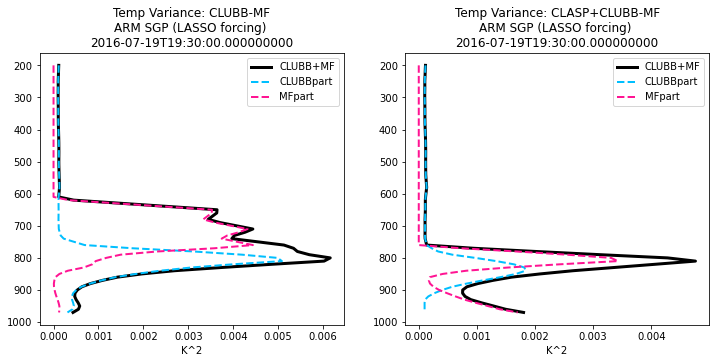

In [27]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_thlp2'
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_S_ATHLTHL_interp'
unitsStr = 'K^2'
varName  = 'Temp Variance'

selTime  = 415

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS[totVar].isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)



Text(0.5, 0, 'm^2 s^-2')

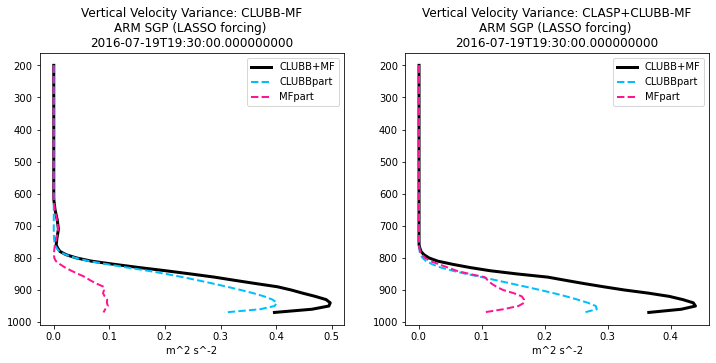

In [28]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_S_AWW_interp'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'

selTime  = 415

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS[totVar].isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)


## Read in obs and LES data too

In [25]:
def preprocess_LES(ds):
    keepVars = ['XTIME','AVS_SH','AVS_LH','AVS_LWP','AVS_RAIN','AVP_QC','AVP_QV',
                'AVP_Z','AVP_P','AVP_THL','AVP_TH','AVP_LWC','AVP_IWC']
    
    dsTimes = ds.Times.load()
    
    times = []
    for iT in range(len(dsTimes.values)):
        timeNow = datetime.datetime.strptime(dsTimes.astype(str).values[iT], '%Y-%m-%d_%H:%M:%S')
        times   = np.append(times, timeNow)

    ds = ds.assign_coords({"Time": times, 
                           "west_east": (ds.west_east.load().values)*0.250,
                           "south_north": (ds.south_north.load().values)*0.250})
    
    ## Convert to local time and drop first time 
    ds['Time'] = ds['Time'].values - np.timedelta64(5, 'h') # And convert to local time by -5hrs 

#     iTimes = np.where(testDS['Time'].values >= (testDS['Time'].values[0] + np.timedelta64(1, 'h')) )[0]
#     testDS = testDS.isel(Time=iTimes)
    
    return ds[keepVars].load()


In [52]:
forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
forcDS       = xr.open_dataset(forcingFile, decode_times=True)

## Convert to local time
localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
forcDS      = forcDS.assign_coords({"time": localTimes})

## Can we get a measure of vertically integrated moisture/temperature convergence? 
g = 9.8 
vertInt_T_adv_h = np.zeros([len(forcDS.time.values)])
vertInt_Q_adv_h = np.zeros([len(forcDS.time.values)])

for iP in range(len(forcDS.lev.values)-1):
    dP = (forcDS.lev.values[iP]-forcDS.lev.values[iP+1])*100.0 # Convert from hPa to Pa

    ## Adding a negative sign outside of the advective terms - 
    ##   These are the values of T and Q divergence, so their negative is *convergence* and easier to interpret
    vertInt_Tadv_levl = dP*(-forcDS.T_adv_h.values[:,iP,0,0]/3600.0) # Convert T_adv units from K/hr to K/s
    vertInt_Qadv_levl = dP*(-forcDS.q_adv_h.values[:,iP,0,0]/3600.0) # Convert Q_adv units from g/kg/hr to g/kg/s

    # Sum over all the levels 
    vertInt_T_adv_h = vertInt_T_adv_h + vertInt_Tadv_levl
    vertInt_Q_adv_h = vertInt_Q_adv_h + vertInt_Qadv_levl

vertInt_T_adv_h = vertInt_T_adv_h/g
vertInt_Q_adv_h = vertInt_Q_adv_h/g

forcDS['vertInt_T_adv_h'] = (('time'), vertInt_T_adv_h)
forcDS['vertInt_Q_adv_h'] = (('time'), vertInt_Q_adv_h)


These files are from a set of WRF-LES runs based on Simon et al. (2021), but an expanded set of 92 total days. <br>
The files containing higher order moments are currently archived here: http://hydrology.cee.duke.edu/CLASP/LES/meg/data_megmoments/ 

In [27]:
datesTXT = '/glade/work/mdfowler/CLASP/LESdata_fromJason/WRFLESdateStrings.txt'

LESdates = pd.read_csv(datesTXT, sep=" ", header=None)
LESdates.columns = ['dateVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(LESdates.dateVal)):
    allYears   = np.append(allYears,   LESdates.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths,  LESdates.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays,    LESdates.dateVal.values.astype(str)[iDate][6::])



In [28]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
daysWithDefault = []
dailymax_LES_thl2 = []

## Counter for how many days have default output
numDaysDefault = 0
dayCounts = 0 

for iDay in range(len(allYears)): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    iDay_SCAM = np.where( (scamDS['time.year']==int(allYears[iDay])) & 
                          (scamDS['time.month']==int(allMonths[iDay])) & 
                          (scamDS['time.day']==int(allDays[iDay])))[0]
    
    
    if ( (int(allYears[iDay])<2019) & (int(allMonths[iDay])>=5) ) :
        if len(iDay_SCAM)>0: 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## Get LES data
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
            HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

            HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
            HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

            # LES_thl2 = xr.concat([HMGds_thl2, HTGds_thl2], "case")
            LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")

            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## Also get forcing data and observations
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            iDay_forcDS   = np.where( (forcDS['time.year']==int(allYears[iDay])) & 
                                      (forcDS['time.month']==int(allMonths[iDay])) & 
                                      (forcDS['time.day']==int(allDays[iDay])) )[0]
            forcDS_daySel = forcDS.isel(time=iDay_forcDS)


            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            ## Just a few more processing steps 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

            ## Get a better time dimension to use  (LES)
            times_LESday = [] 
            for iT in range(len(LES_allVars.time.values)): 
                timeStep     = startTime + timedelta(minutes = int(LES_allVars.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
                times_LESday = np.append(times_LESday, timeStep)

            LES_allVars['datetime'] = (('time'), times_LESday)
            LES_allVars             = LES_allVars.set_index(time='datetime')

            ## Combine into one array 
            if dayCounts==0: 
                # LES_allDays_thl2    = LES_thl2
                LES_allDays_allVars = LES_allVars
                forcDS_allDays      = forcDS_daySel
            else:
                # LES_allDays_thl2    = xr.concat([LES_allDays_thl2, LES_thl2], "time")
                LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
                forcDS_allDays      = xr.concat([forcDS_allDays, forcDS_daySel], "time") 
            dayCounts = dayCounts+1


            del LES_allVars

            # if os.path.isdir(HTGdir)==True: 
            #     del LES_default

            print('Done with ', dateString)
        else:
            print('Skipping '+dateString)

    

Done with  20150606
Done with  20150609
Done with  20150627
Done with  20150801
Done with  20150829
Done with  20160518
Done with  20160530
Done with  20160610
Done with  20160611
Done with  20160614
Done with  20160619
Done with  20160625
Done with  20160716
Done with  20160719
Done with  20160720
Done with  20160818
Done with  20160819
Done with  20160830
Done with  20170509
Done with  20170524
Done with  20170527
Done with  20170605
Done with  20170609
Done with  20170614
Done with  20170626
Done with  20170627
Done with  20170629
Done with  20170630
Done with  20170704
Done with  20170705
Done with  20170709
Done with  20170712
Done with  20170716
Done with  20170717
Done with  20170719
Done with  20170720
Done with  20170721
Done with  20170725
Done with  20170728
Done with  20170802
Done with  20170826
Done with  20170828
Done with  20170830
Done with  20170922
Done with  20170923
Done with  20170924
Done with  20180514
Done with  20180522
Done with  20180523
Done with  20180529


In [29]:
## Resample the moments to be hourly (means are listed for the hour they start in; so "8a" =mean over 8a, 8:10, 8:20, etc) 
LES_allDays_allVarsHr         = LES_allDays_allVars.resample(time='1H').mean(dim='time').dropna(dim='time')
LES_allDays_allVars30m        = LES_allDays_allVars.resample(time='30Min').mean(dim='time').dropna(dim='time')

## Add thirty minutes to match the other LES output better 
LES_allDays_allVarsHr['time'] = LES_allDays_allVarsHr['time'] + np.timedelta64(30, 'm')

## For consistency with other LES files, let's also only get means through hour 21
iHrsSel               = np.where(LES_allDays_allVarsHr['time.hour'].values<22)[0]
LES_allDays_allVarsHr = LES_allDays_allVarsHr.isel(time=iHrsSel)


Similar to above, the broader set of WRF-LES output is archived here: http://hydrology.cee.duke.edu/CLASP/LES/diags2/

In [30]:
newLESdefDir = '/glade/campaign/cgd/tss/mdfowler/CLASP_LES_data/hydrology.cee.duke.edu/'
HTGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_00'))
HMGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_01'))


for iHTG in range(len(HTGdirs)):
    filesHTG  = np.sort(glob.glob(HTGdirs[iHTG]+'/*.nc4'))
    
    htgLESnew = xr.open_mfdataset(filesHTG,  preprocess=preprocess_LES, concat_dim='Time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

    if iHTG==0:
        HTGnew_allDays = htgLESnew
    else:
        HTGnew_allDays = xr.concat([HTGnew_allDays, htgLESnew], "Time")
    
    
    
for iHMG in range(len(HMGdirs)):    
    filesHMG = np.sort(glob.glob(HMGdirs[iHMG]+'/*.nc4'))

    hmgLESnew = xr.open_mfdataset(filesHMG,  preprocess=preprocess_LES, concat_dim='Time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal')
    
    if iHMG==0:
        HMGnew_allDays = hmgLESnew
    else:
        HMGnew_allDays = xr.concat([HMGnew_allDays, hmgLESnew], "Time")
        

print('Done reading in new LES cases')

HTGnew_allDays = HTGnew_allDays.assign_coords({"case": 'HTG'})
HMGnew_allDays = HMGnew_allDays.assign_coords({"case": 'HMG'})

LES_newDefault = xr.concat([HMGnew_allDays, HTGnew_allDays], "case")


Done reading in new LES cases


In [31]:
## Drop the first hour (7a) - this is just the initial state, not LES simulated 
iHrsSel        = np.where(LES_newDefault['Time.hour'].values>7)[0]
LES_newDefault = LES_newDefault.isel(Time=iHrsSel)

## LES times were recorded at the *end* of the hour, so just shift into the hour's mean they represent 
LES_newDefault['Time'] = LES_newDefault.Time - np.timedelta64(30, 'm')


## Use the same days in WRF-LES and in SCAM

In [32]:
uniqDays_scamHMG = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_LES     = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms    = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values

print('SCAM days:    ',     len(uniqDays_scamHMG))
print('LES days:     ',     len(uniqDays_LES))
print('Moments days: ',     len(uniqDays_moms))
    

SCAM days:     74
LES days:      92
Moments days:  74


In [33]:
keepDates = pd.DatetimeIndex(np.sort( list(set(uniqDays_scamHMG) & 
                                           set(uniqDays_LES) & set(uniqDays_moms) ) ))

iKeep_SCAM   = []
iKeep_LES    = []
iKeep_moms   = []
iKeep_moms30 = []
iKeep_forc   = []

for iDate in range(len(keepDates)):
    iSCAM = np.where( (scamDS.sel(case='clubbMF')['time.year'].values == keepDates[iDate].year) & 
                      (scamDS.sel(case='clubbMF')['time.month'].values == keepDates[iDate].month) & 
                      (scamDS.sel(case='clubbMF')['time.day'].values == keepDates[iDate].day))[0]
    
    ## Let's also make sure that each *case* in SCAM has all the days (missing some at end of 2018)
    # testCasesValid = scamDS.isel(time=iSCAM,lat=0,lon=0).SHFLX.values[:,0]
    # if np.sum(np.isfinite(testCasesValid))==len(scamDS.case.values): 
    iKeep_SCAM = np.append(iKeep_SCAM, iSCAM)
    
    
    iLES  = np.where( (LES_newDefault.sel(case='HMG')['Time.year'].values == keepDates[iDate].year) & 
                      (LES_newDefault.sel(case='HMG')['Time.month'].values == keepDates[iDate].month) & 
                      (LES_newDefault.sel(case='HMG')['Time.day'].values == keepDates[iDate].day))[0]
    iKeep_LES = np.append(iKeep_LES, iLES)
    
    
    iMoments = np.where( (LES_allDays_allVarsHr.sel(case='HMG')['time.year'].values == keepDates[iDate].year) & 
                         (LES_allDays_allVarsHr.sel(case='HMG')['time.month'].values == keepDates[iDate].month) & 
                         (LES_allDays_allVarsHr.sel(case='HMG')['time.day'].values == keepDates[iDate].day))[0]
    iKeep_moms = np.append(iKeep_moms, iMoments)    
    
    
    iMoments30   = np.where( (LES_allDays_allVars30m.sel(case='HMG')['time.year'].values == keepDates[iDate].year) & 
                             (LES_allDays_allVars30m.sel(case='HMG')['time.month'].values == keepDates[iDate].month) & 
                             (LES_allDays_allVars30m.sel(case='HMG')['time.day'].values == keepDates[iDate].day))[0]
    iKeep_moms30 = np.append(iKeep_moms30, iMoments30)   

    iForc = np.where( (forcDS['time.year'].values == keepDates[iDate].year) & 
                      (forcDS['time.month'].values == keepDates[iDate].month) & 
                      (forcDS['time.day'].values == keepDates[iDate].day) & 
                      (forcDS['time.hour'].values >= 7) &
                      (forcDS['time.hour'].values <= 21) )[0]
    iKeep_forc = np.append(iKeep_forc, iForc)
    
    
## Limit to matching dates 
scamDS                 = scamDS.isel(time=iKeep_SCAM.astype(int))
scamDS_h2              = scamDS_h2.isel(time=iKeep_SCAM.astype(int))

LES_newDefault         = LES_newDefault.isel(Time=iKeep_LES.astype(int))
LES_allDays_allVarsHr  = LES_allDays_allVarsHr.isel(time=iKeep_moms.astype(int))
LES_allDays_allVars30m = LES_allDays_allVars30m.isel(time=iKeep_moms30.astype(int))
forcDS                 = forcDS.isel(time=iKeep_forc.astype(int))

clmDS_h0               = clmDS_h0.isel(time=iKeep_SCAM.astype(int))
clmDS_h1               = clmDS_h1.isel(time=iKeep_SCAM.astype(int))


In [46]:
## Now do we have the same number of days?
uniqDays_scam = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_LES  = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_forc = forcDS.resample(time='1D').mean().dropna(dim='time').time

print('SCAM days:    ',    len(uniqDays_scam))
print('LES days:     ',    len(uniqDays_LES))
print('Moments days: ',    len(uniqDays_moms))


SCAM days:     74
LES days:      74
Moments days:  74


### Aside: look for good target days for CLUBB-MF

In [64]:
forcDS.prec_srf


<xarray.DataArray 'prec_srf' (time: 33600, lat: 1, lon: 1)>
array([[[0.      ]],

       [[0.      ]],

       ...,

       [[0.166816]],

       [[0.092483]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31T19:00:00 ... 2018-10-31T17:49:2...
  * lat      (lat) float32 36.61
  * lon      (lon) float32 -97.49
Attributes:
    units:          mm/hour
    long_name:      Surface precipitation
    standard_name:  lwe_precipitation_rate
    version:        v2
    source:         Rain gauge adjusted WSR-88D radar precipitation - ABRFC

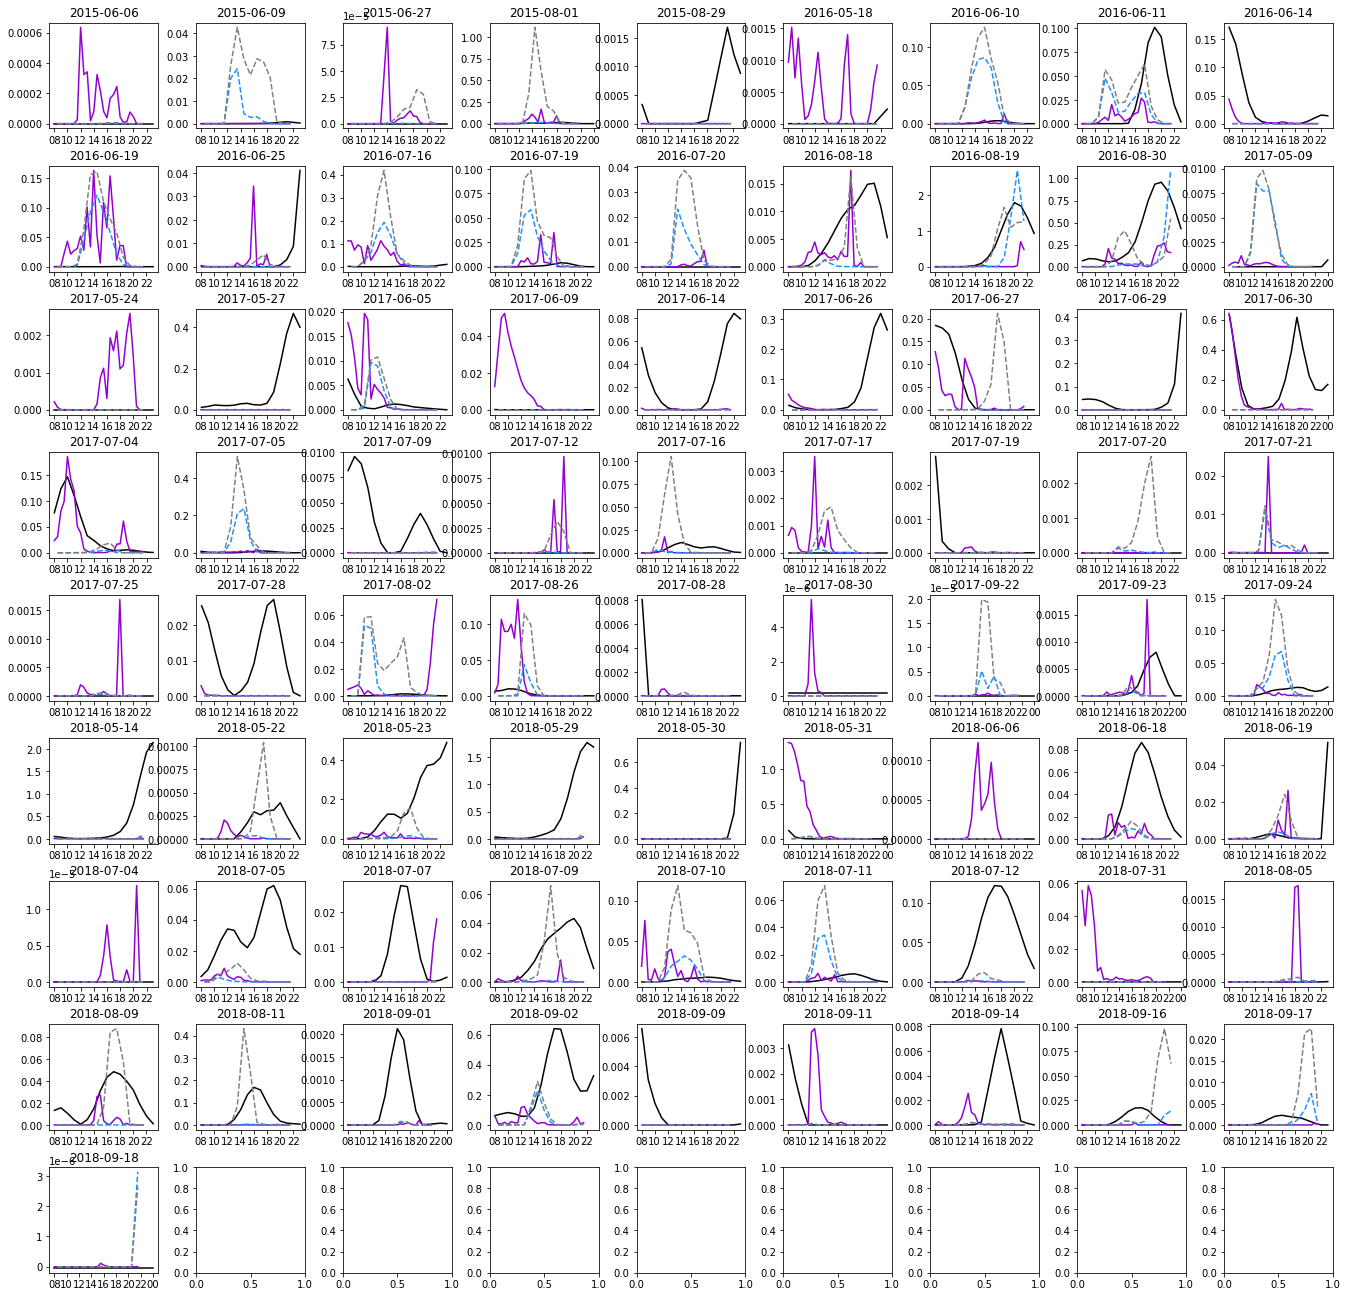

In [63]:
fig,axs = plt.subplots(9,9,figsize=(23,23))
axs     = axs.ravel()

## Convert rain to be mm/hr for everythign, as in forcDS (obs)
LESmeanRain     = LES_newDefault['AVS_RAIN'].mean(("south_north", "west_east"))
LES_newDefault['meanRain'] = (('case','Time'), LESmeanRain*3600)  ## Convert units to mm/hr, not mm/s

for iDay in range(len(uniqDays_forc)):
    ## Get obs day
    iTimes_forc = np.where( (forcDS['time.year'].values  == uniqDays_forc['time.year'].values[iDay]) & 
                            (forcDS['time.month'].values == uniqDays_forc['time.month'].values[iDay]) &  
                            (forcDS['time.day'].values   == uniqDays_forc['time.day'].values[iDay]) & 
                            (forcDS['time.hour'].values>=8) )[0]
    forcDS_day = forcDS.isel(time=iTimes_forc)
    
    ## Get LES day
    iTimes_les = np.where( (LES_newDefault['Time.year'].values  == uniqDays_forc['time.year'].values[iDay]) & 
                            (LES_newDefault['Time.month'].values == uniqDays_forc['time.month'].values[iDay]) &  
                            (LES_newDefault['Time.day'].values   == uniqDays_forc['time.day'].values[iDay]) & 
                            (LES_newDefault['Time.hour'].values>=8) )[0]
    les_day = LES_newDefault.isel(Time=iTimes_les)
    
    ## Get SCAM day
    iTimes_scam = np.where( (scamDS['time.year'].values  == uniqDays_forc['time.year'].values[iDay]) & 
                            (scamDS['time.month'].values == uniqDays_forc['time.month'].values[iDay]) &  
                            (scamDS['time.day'].values   == uniqDays_forc['time.day'].values[iDay]) & 
                            (scamDS['time.hour'].values>=8) )[0]
    scam_day = scamDS.isel(time=iTimes_scam)
    
    

    ## Plot the LASSO rainfall 
    axs[iDay].plot(forcDS_day['time'].values, np.squeeze(forcDS_day.prec_srf.values),'k-')
    axs[iDay].set_title(uniqDays_forc.isel(time=iDay).time.values.astype(str)[0:10])
    
    ## Plot SCAM rainfall
    axs[iDay].plot(scam_day['time'].values, np.squeeze(scam_day['PRECT'].sel(case='clubbMF').values)*3600*1000, '-',color='darkviolet')
    
    ## Plot LES rainfall 
    axs[iDay].plot(les_day['Time'].values, np.squeeze(les_day['meanRain'].sel(case='HMG').values), '--',color='dodgerblue')
    axs[iDay].plot(les_day['Time'].values, np.squeeze(les_day['meanRain'].sel(case='HTG').values), '--',color='grey')

    
    axs[iDay].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

fig.subplots_adjust(hspace = 0.35, wspace=0.35)
plt.savefig("LESandLASSOandSCAM_rainRates.pdf", format="pdf", bbox_inches="tight")


## Plots and Analysis 

### PDFs

In [39]:
## Convert rain to be mm/hr for everythign, as in forcDS (obs)
LESmeanRain     = LES_newDefault['AVS_RAIN'].mean(("south_north", "west_east"))
LES_newDefault['meanRain'] = (('case','Time'), LESmeanRain*3600)  ## Convert units to mm/hr, not mm/s

## Get rain rates only when it's actually raining...
rainRatesHMG_les = LES_newDefault.meanRain.sel(case='HMG').values
rainRatesHMG_les = rainRatesHMG_les[np.where(rainRatesHMG_les>0)[0]]

rainRatesHTG_les = LES_newDefault.meanRain.sel(case='HTG').values
rainRatesHTG_les = rainRatesHTG_les[np.where(rainRatesHTG_les>0)[0]]


In [40]:
scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]


In [41]:
rainRateObs = forcDS.prec_srf.values
rainRateObs = rainRateObs[np.where(rainRateObs>0)[0]]

[None]

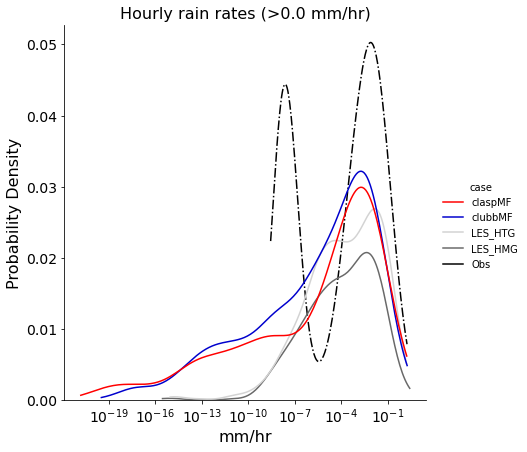

In [42]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF'}),
         
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_les), 'case': 'LES_HTG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_les), 'case': 'LES_HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRateObs), 'case': 'Obs'})
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['red','mediumblue','lightgrey','dimgrey','black'], legend=True)

# g.ax.set_xlim([10**-13, 10**1])
g.ax.set_title("Hourly rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
# plt.setp(g._legend.get_title(), fontsize=14)
# plt.setp(g._legend.get_texts(), fontsize=14)
plt.setp(g.ax.lines[0], linestyle='-.')   # Index goes in reverse order 
plt.setp(g.ax.lines[2], linestyle='-')   # Index goes in reverse order  
# plt.legend(loc='upper left', 
#            labels=['Obs','LES_HMG','LES_HTG','SCAM_HMG','SCAM_HTG',r"SCAM_HTG$_\alpha$",r"SCAM_HTG$_{100}$"], 
#            ncol=2, fontsize=12)




(0.0, 0.3)

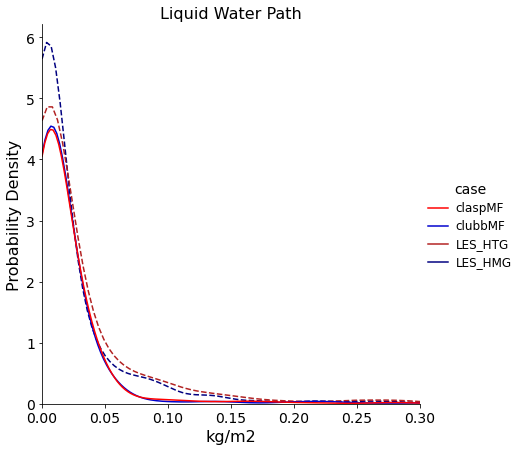

In [43]:
scamTMQ  = scamDS.TGCLDLWP.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamTMQ['time.hour'].values<=19)[0]
scamTMQ  = scamTMQ.isel(time=selHours)

LESlwp      = LES_newDefault['AVS_LWP'].mean(("south_north", "west_east"))
selHoursLES = np.where(LESlwp['Time.hour'].values<=19)[0]
LESlwp      = LESlwp.isel(Time=selHoursLES)
lwpHMG_les  = LESlwp.sel(case='HMG').values[np.where(LESlwp.sel(case='HMG').values>0)[0]]
lwpHTG_les  = LESlwp.sel(case='HTG').values[np.where(LESlwp.sel(case='HTG').values>0)[0]]

# SCAM
tmqHMG_scam = scamTMQ.sel(case='clubbMF').values[np.where(scamTMQ.sel(case='clubbMF').values>0)[0]]
tmqHTG_scam = scamTMQ.sel(case='clasp+MF').values[np.where(scamTMQ.sel(case='clasp+MF').values>0)[0]]


dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'LWP': np.squeeze(tmqHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'LWP': np.squeeze(tmqHMG_scam), 'case': 'clubbMF'}),
         pd.DataFrame.from_dict({'LWP': np.squeeze(lwpHTG_les), 'case': 'LES_HTG'}),
         pd.DataFrame.from_dict({'LWP': np.squeeze(lwpHMG_les), 'case': 'LES_HMG'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='LWP', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue','firebrick','navy'])

g.ax.set_title("Liquid Water Path", fontsize=16 ) 
g.ax.set_xlabel('kg/m2',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g.ax.lines[0], linestyle='--')   # Index goes in reverse order 
plt.setp(g.ax.lines[1], linestyle='--')   # Index goes in reverse order 

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.set_xlim([0,0.3])


[None, None, None, None]

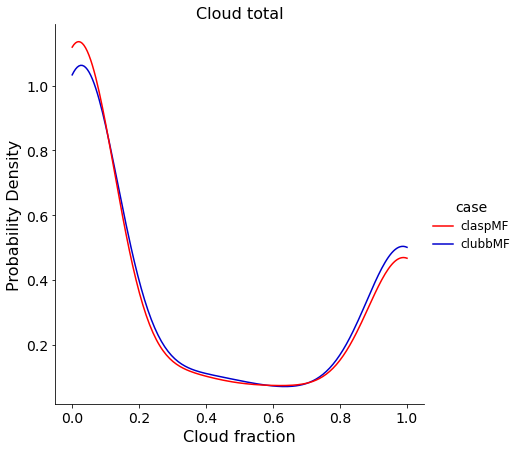

In [44]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamCLD['time.hour'].values<=19)[0]
scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF').values
cldHTG_scam = scamCLD.sel(case='clasp+MF').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


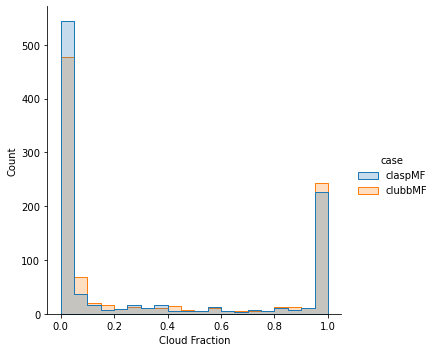

In [45]:
sns.displot(dfReal, x='Cloud Fraction',hue='case',element='step',binwidth=0.05)

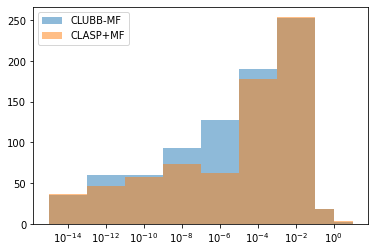

In [46]:
binEdges = [10e-16, 10e-14, 10e-12, 10e-10, 10e-8, 10e-6, 10e-4, 10e-2, 10e-1,10]

plt.hist(np.squeeze(rainRatesHMG_scam),alpha = 0.5, bins=binEdges)
plt.hist(np.squeeze(rainRatesHTG_scam), alpha=0.5, bins=binEdges)

plt.xscale('log')
plt.legend(['CLUBB-MF', 'CLASP+MF'])


In [47]:
upthl_clubbMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clubbMF')
upthl_claspMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clasp+MF')

countValPlumes_clubb = np.zeros([len(upthl_clubbMF.levInterp.values)])
countValPlumes_clasp = np.zeros([len(upthl_clubbMF.levInterp.values)])

for iLev in range(len(upthl_clubbMF.levInterp.values)):
    countValPlumes_clubb[iLev] = np.shape(np.where( np.isfinite(upthl_clubbMF.isel(levInterp=iLev))==True))[1]
    countValPlumes_clasp[iLev] = np.shape(np.where( np.isfinite(upthl_claspMF.isel(levInterp=iLev))==True))[1]


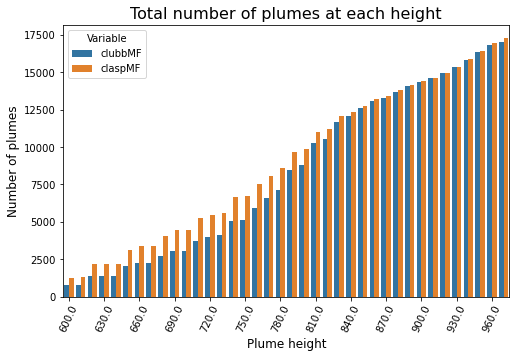

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))    

levs = upthl_claspMF.levInterp.values
dfLevInfo = pd.DataFrame({'Level': levs[40::],
                          'clubbMF': countValPlumes_clubb[40::], 
                          'claspMF': countValPlumes_clasp[40::]})
tidy = dfLevInfo.melt(id_vars='Level').rename(columns=str.title)

g = sns.barplot(x='Level',y='Value',hue='Variable',data=tidy)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::3])
plt.xticks(rotation=65)
ax.set_ylabel('Number of plumes',fontsize=12)
ax.set_xlabel('Plume height',fontsize=12)
ax.set_title('Total number of plumes at each height', fontsize=16)

plt.show()

### Diurnal cycle plots

In [49]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')

hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')

# ## Get mean hourly LES values too 
# hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
# hrLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')



In [50]:
# pltVar = 'RTPTHLP_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# # ctrlCase2 = 'clubbMF_setSfcFlux'
# # testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*1e-3, 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*1e-3, 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*1e-3, 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*1e-3, 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K kg/kg')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)


In [51]:
# pltVar = 'THLP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values), 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)



In [52]:
# pltVar = 'RTP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='dodgerblue', linestyle='--', label=testCase2)


# axs.legend(fontsize=12)

# axs.set_ylabel('kg**2/kg**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)




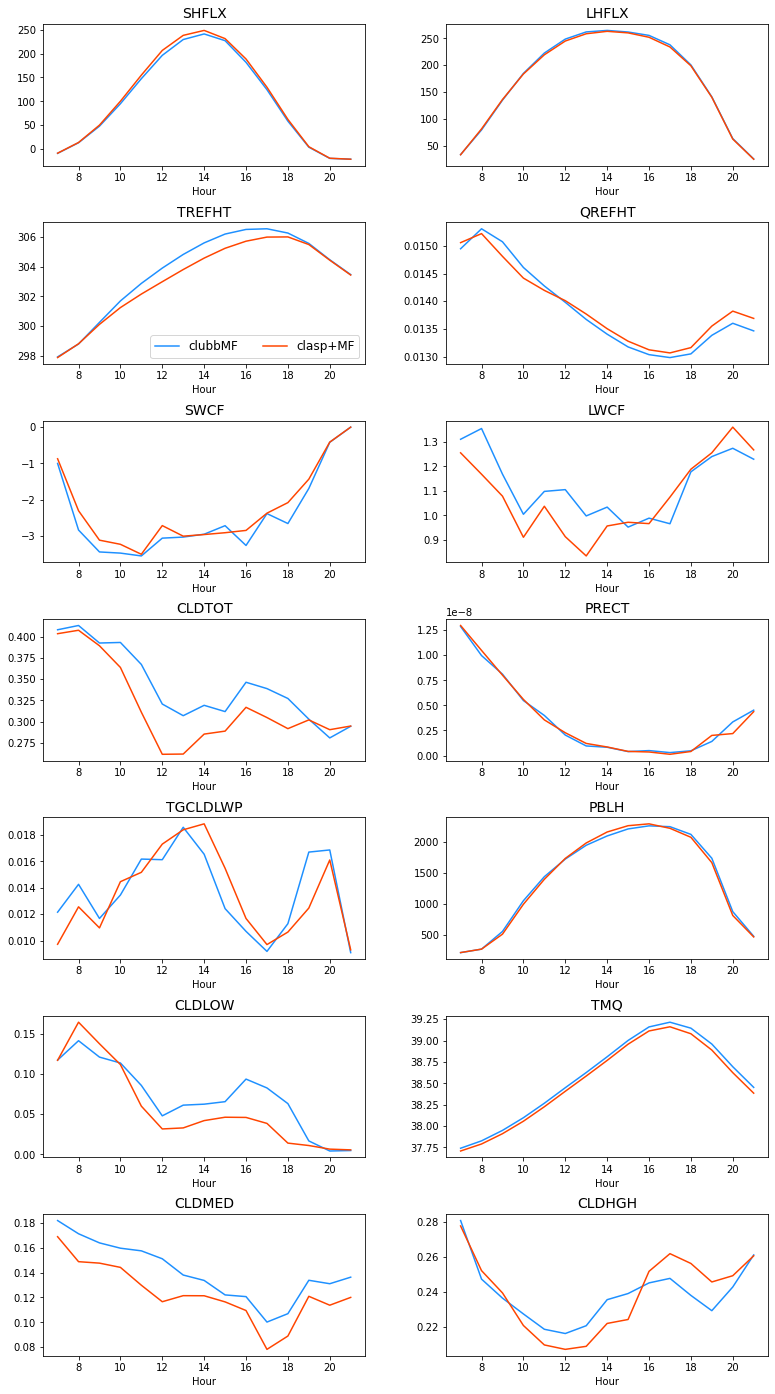

In [53]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ',
           'CLDMED','CLDHGH']

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

ctrlCase2 = 'clubbMF_setSfcFlux'
testCase2 = 'claspMF_setSfcFlux'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
    
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    if iPlt==2:
        axs[iPlt].legend(fontsize=12, ncol=2)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


In [54]:
uniqDays_scamHMG = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
print('SCAM days:    ',    len(uniqDays_scamHMG))
dates            = pd.DatetimeIndex(uniqDays_scamHMG)


SCAM days:     74


In [55]:
# pltVars = [
#            'PRECT',
#            'TGCLDLWP',
#            ]

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(11,3.25*len(pltVars)/2) )
# axs      = axs.ravel()
# fig.subplots_adjust(wspace=0.25, hspace=0.4)

# for iPlt in range(len(pltVars)):

# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=3, label=ctrlCase)
# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
# #              color='dodgerblue',linewidth=3, label=testCase)
# #     axs[iPlt].legend(fontsize=12)
    
#     for iDay in range(len(dates)):
#         iselDate = np.where( (scamDS['time.year'].values==dates.year[iDay]) & 
#                              (scamDS['time.month'].values==dates.month[iDay]) & 
#                              (scamDS['time.day'].values==dates.day[iDay]) )[0]
#         scamSel = scamDS.isel(time=iselDate).groupby('time.hour').mean(dim='time')
        
# #         axs[iPlt].plot(scamSel['hour'].values, np.squeeze(scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=0.5,alpha=0.4, label=ctrlCase)
#         axs[iPlt].plot(scamSel['hour'].values, 
#                        np.squeeze(scamSel[pltVars[iPlt]].sel(case=testCase).values - scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
#              color='k',linewidth=0.5,alpha=0.4, label=testCase)

#     # axs.set_ylabel('K kg/kg')
#     axs[iPlt].set_xlabel('Hour')
#     axs[iPlt].set_title(pltVars[iPlt]+' [clasp - clubb]', fontsize=14)


### Mean profiles at certain hours?

(-0.5, 5.0)

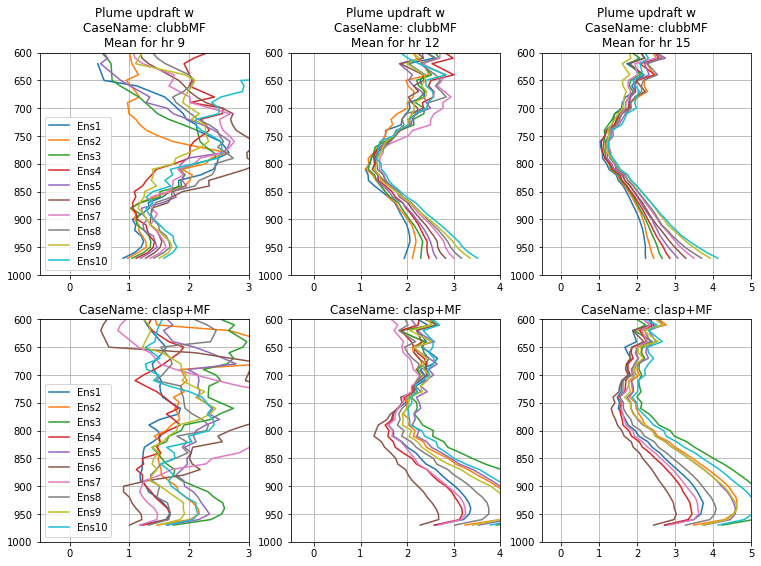

In [56]:
hoursList = [9,12,15]
fig,axs = plt.subplots(2,len(hoursList), figsize=(4.25*len(hoursList),9))
axs = axs.ravel()

caseSel1 = 'clubbMF'
caseSel2 = 'clasp+MF'
# caseSel1 = 'clubbMF_setSfcFlux'
# caseSel2 = 'claspMF_setSfcFlux'

# varSel   = 'edmf_upqt_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft qt'

# varSel   = 'edmf_upthl_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft thl'

varSel   = 'up_macmicAvg_interp' 
levVar   = 'levInterp'
longName = 'Plume updraft w'

# varSel   = 'edmf_upbuoy_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft buoyancy'

# varSel   = 'edmf_updet_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft detrainment'

# varSel   = 'edmf_upa_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft area'

for iHour in range(len(hoursList)):
    hourSel = hoursList[iHour]

    for iEns in range(len(hourlyMeanSCAM_h2.nens.values)):
        ensSel1 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel1).isel(lon=0,lat=0,nens=iEns)
        ensSel2 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel2).isel(lon=0,lat=0,nens=iEns)

        axs[iHour].plot(ensSel1[varSel].values, ensSel1[levVar].values, label='Ens'+str(iEns+1))
        axs[iHour+3].plot(ensSel2[varSel].values, ensSel2[levVar].values, label='Ens'+str(iEns+1))

    if iHour==0:
        axs[iHour].legend()
        axs[iHour+3].legend()
    
    axs[iHour].invert_yaxis()
    axs[iHour+3].invert_yaxis()

    axs[iHour].set_ylim([1000,600])
    axs[iHour+3].set_ylim([1000,600])

    axs[iHour].set_title(longName+'\nCaseName: '+caseSel1+'\nMean for hr '+str(hourSel))
    axs[iHour+3].set_title('CaseName: '+caseSel2)

    axs[iHour].grid()
    axs[iHour+3].grid()

# # EDMF_upthl limits: 
# axs[0].set_xlim([294,306])
# axs[3].set_xlim([294,306])

# axs[1].set_xlim([303,315])
# axs[4].set_xlim([303,315])

# axs[2].set_xlim([305,315])
# axs[5].set_xlim([305,315])

# # EDMF_upqt limits: 
# axs[0].set_xlim([0.01,0.0145])
# axs[3].set_xlim([0.01,0.0145])

# axs[1].set_xlim([0.008, 0.012])
# axs[4].set_xlim([0.008, 0.012])

# axs[2].set_xlim([0.008, 0.0115])
# axs[5].set_xlim([0.008, 0.0115])

# EDMF_upw limits: 
axs[0].set_xlim([-0.5,3])
axs[3].set_xlim([-0.5,3])

axs[1].set_xlim([-0.5, 4])
axs[4].set_xlim([-0.5, 4])

axs[2].set_xlim([-0.5, 5])
axs[5].set_xlim([-0.5, 5])



(300.0, 315.0)

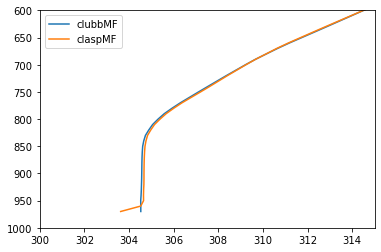

In [50]:
fig,axs = plt.subplots(1,1, figsize=(6,4))

hrSel = 15

axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clubbMF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='clubbMF')
axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clasp+MF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='claspMF')
axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,600])
axs.set_xlim([300,315])


KeyError: 'total_wp2'

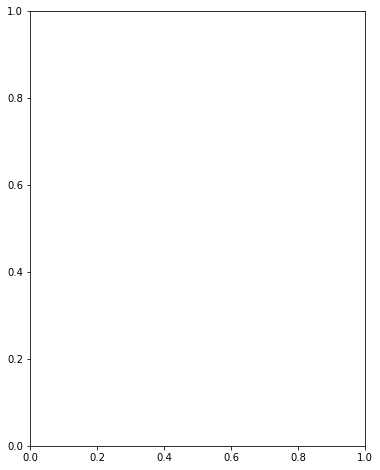

In [51]:
fig,axs = plt.subplots(1,1, figsize=(6,8))

# totVar   = 'total_thlp2'
# clubbVar = 'THLP2_CLUBB_interp'
# mfVar    = 'edmf_thlp2'
# unitsStr = 'K^2'
# varName  = 'Temp Variance'


totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_wp2'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'


maxLev   = 600 
selHr    = 15

colorsel = ['black','deepskyblue','deeppink']

axs.plot(hourlyMeanSCAM_h2[totVar].sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='black',linestyle='-', linewidth=3, 
            label='Total_clubbMF')
axs.plot(hourlyMeanSCAM_h2[totVar].sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='dimgrey',linestyle='--', linewidth=3, 
            label='Total_claspMF')

axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='dodgerblue',linestyle='-', linewidth=2, 
            label='CLUBB_clubbMF')
axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='deepskyblue',linestyle='--', linewidth=2, 
            label='CLUBB_claspMF')

axs.plot(hourlyMeanSCAM_h2[mfVar].sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='darkviolet',linestyle='-', linewidth=2, 
            label='MF_clubbMF')
axs.plot(hourlyMeanSCAM_h2[mfVar].sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='deeppink',linestyle='--', linewidth=2, 
            label='MF_claspMF')

# axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS.levInterp.values, 
#             color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
#             label='CLUBBpart')

# axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS_h2.levInterp.values, 
#             color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
#             label='MFpart')


axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,maxLev])
axs.set_title(varName+': Mean for local hour '+str(selHr))
axs.set_xlabel(unitsStr)

# axs.axvline(0,color='orange',alpha=0.9,linestyle=':')

In [83]:
sumVar = hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr) + hourlyMeanSCAM_h2[mfVar].sel(case='clubbMF',hour=selHr) 



In [84]:
for ilev in range(len(hourlyMeanSCAM.levInterp.values)):
    if sumVar[ilev]==hourlyMeanSCAM_h2[totVar].isel(levInterp=ilev).sel(case='clubbMF',hour=selHr):
        print('cool, match at level ', hourlyMeanSCAM.levInterp.values[ilev])
    else:
        print('ERROR at level ', hourlyMeanSCAM.levInterp.values[ilev])
        print('   sumVar = ',sumVar[ilev].values)
        print('   levVar = ',hourlyMeanSCAM_h2[totVar].isel(levInterp=ilev).sel(case='clubbMF',hour=selHr).values)
    

ERROR at level  200.0
   sumVar =  nan
   levVar =  0.00047549840388336
ERROR at level  210.0
   sumVar =  nan
   levVar =  0.0007945166030795027
ERROR at level  220.0
   sumVar =  nan
   levVar =  0.0025257933319838906
ERROR at level  230.0
   sumVar =  nan
   levVar =  0.004849850946898459
ERROR at level  240.0
   sumVar =  nan
   levVar =  0.006142215692338495
ERROR at level  250.0
   sumVar =  nan
   levVar =  0.008105069775268701
ERROR at level  260.0
   sumVar =  nan
   levVar =  0.011150786346805545
ERROR at level  270.0
   sumVar =  nan
   levVar =  0.013017800301513574
ERROR at level  280.0
   sumVar =  nan
   levVar =  0.01414544381843339
ERROR at level  290.0
   sumVar =  nan
   levVar =  0.015391724282369564
ERROR at level  300.0
   sumVar =  nan
   levVar =  0.016919504477302703
ERROR at level  310.0
   sumVar =  nan
   levVar =  0.016971378353168892
ERROR at level  320.0
   sumVar =  nan
   levVar =  0.016490302313795415
ERROR at level  330.0
   sumVar =  nan
   levVar = 

### Look at mean over certain periods

In [73]:
iMorn = np.where((scamDS['time.hour'].values>=8) & (scamDS['time.hour'].values<=10))[0]
iAftn = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=17))[0]
iEvng = np.where((scamDS['time.hour'].values>=18) & (scamDS['time.hour'].values<=20))[0]

mornDS = scamDS.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS = scamDS.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS = scamDS.isel(time=iEvng, lat=0, lon=0).mean(dim='time')

mornDS_h2 = scamDS_h2.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS_h2 = scamDS_h2.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS_h2 = scamDS_h2.isel(time=iEvng, lat=0, lon=0).mean(dim='time')


In [74]:
tableVars = ['PRECT','CLDTOT','TGCLDLWP','TMQ','CLDLOW','CLDHGH','SWCF','LWCF']

print('                                       clubb/clasp')
print('                    (8-10a)             (12-5p)                (6-8p)')
print('Variable          MorningMean        AfternoonMean        EveningMean')
  
for iVar in range(len(tableVars)):
    print('%10s  %8.3f / %7.3f  %8.3f / %7.3f  %8.3f / %7.3f' % (tableVars[iVar], 
                    mornDS[tableVars[iVar]].sel(case='clubbMF'), mornDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    aftnDS[tableVars[iVar]].sel(case='clubbMF'), aftnDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    evngDS[tableVars[iVar]].sel(case='clubbMF'), evngDS[tableVars[iVar]].sel(case='clasp+MF'), 
                                  ) )
    
    

                                       clubb/clasp
                    (8-10a)             (12-5p)                (6-8p)
Variable          MorningMean        AfternoonMean        EveningMean
     PRECT     0.000 /   0.000     0.000 /   0.000     0.000 /   0.000
    CLDTOT     0.400 /   0.387     0.324 /   0.286     0.304 /   0.295
  TGCLDLWP     0.013 /   0.013     0.014 /   0.015     0.015 /   0.013
       TMQ    37.958 /  37.919    38.876 /  38.832    38.933 /  38.864
    CLDLOW     0.126 /   0.138     0.069 /   0.040     0.028 /   0.010
    CLDHGH     0.237 /   0.237     0.234 /   0.229     0.237 /   0.250
      SWCF    -3.246 /  -2.880    -2.898 /  -2.799    -1.587 /  -1.308
      LWCF     1.176 /   1.052     1.007 /   0.953     1.231 /   1.268


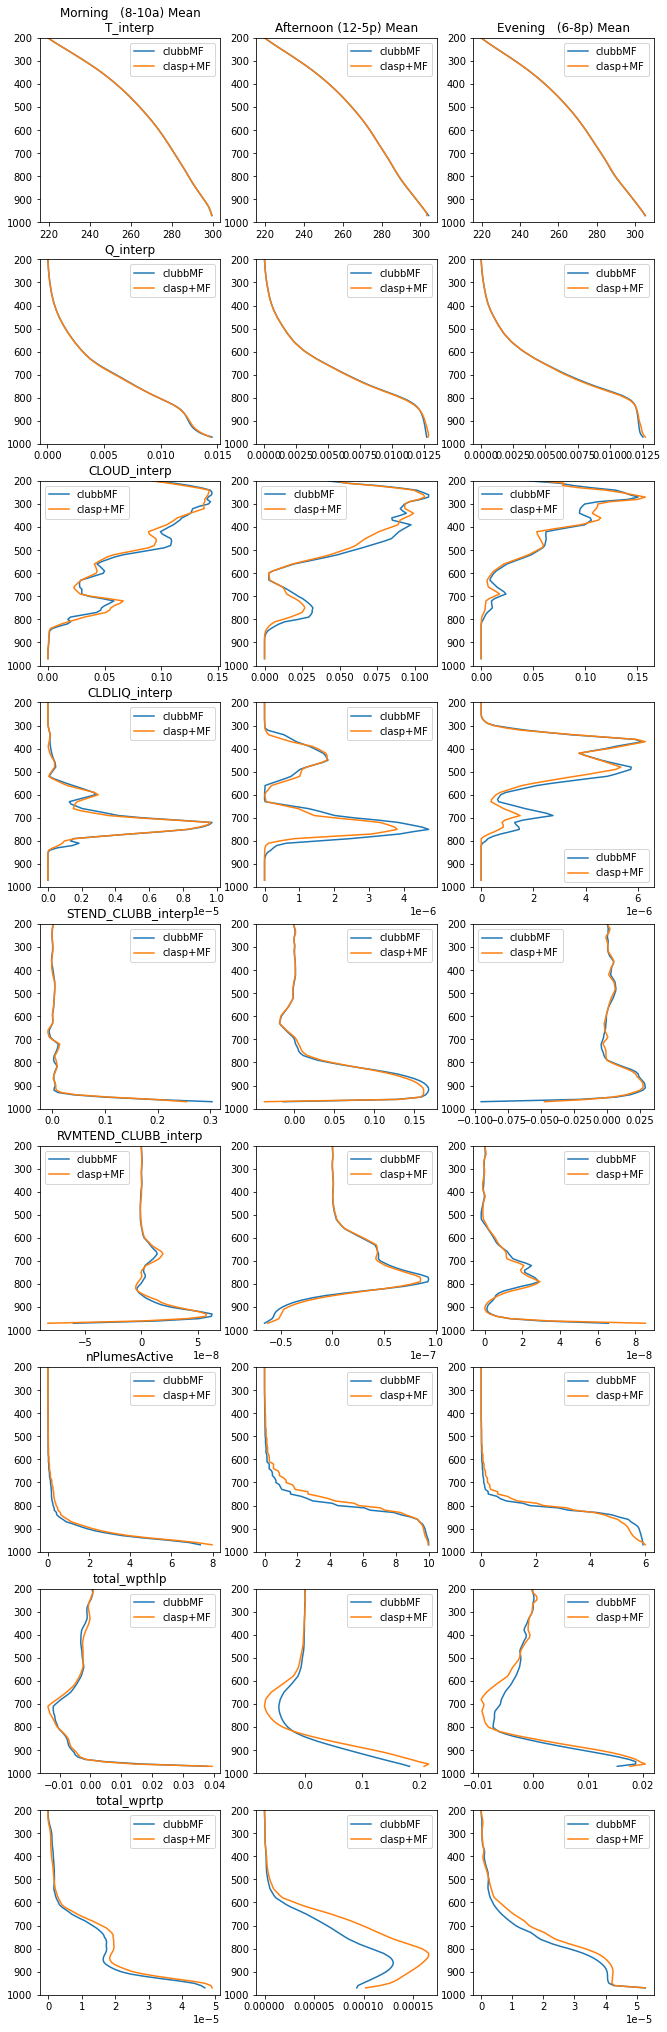

In [59]:
pltVars = ['T_interp','Q_interp','CLOUD_interp','CLDLIQ_interp',
           'STEND_CLUBB_interp','RVMTEND_CLUBB_interp',
           'nPlumesActive',
           'total_wpthlp','total_wprtp']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [280, 0.005, -0.01, -0.1e-5, 280, 0.005]
maxX = [308, 0.013, 0.06,  1.2e-5, 308, 0.013]

useH2 = False

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values, 
                           mornDS_h2.levInterp.values)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])

    

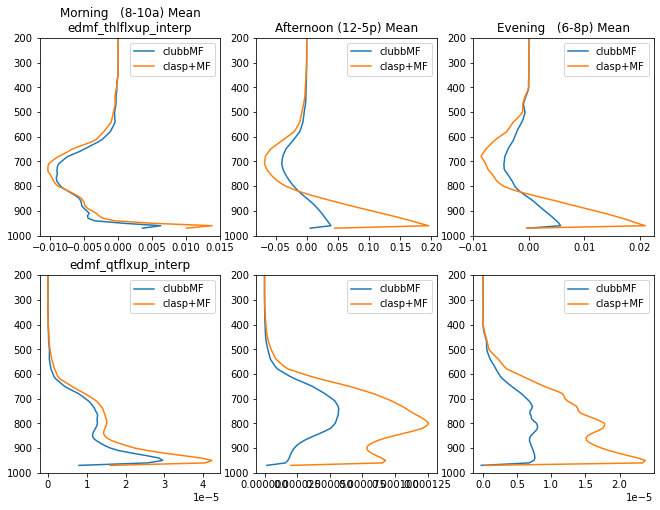

In [60]:
pltVars = ['edmf_thlflxup_interp', 'edmf_qtflxup_interp']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [ -0.01, -0.1e-5]
maxX = [ 0.06,  1.2e-5]

useH2 = True

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS_h2.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS_h2.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS_h2.levInterp.values, label=testCase)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])
    

### Look at days where afternoon cloudiness increased

In [61]:
iAftn = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=17))[0]

aftnDS    = scamDS.isel(time=iAftn, lat=0, lon=0).resample(time='1D').mean().dropna(dim='time')
aftnDS_h2 = scamDS_h2.isel(time=iAftn, lat=0, lon=0).resample(time='1D').mean()


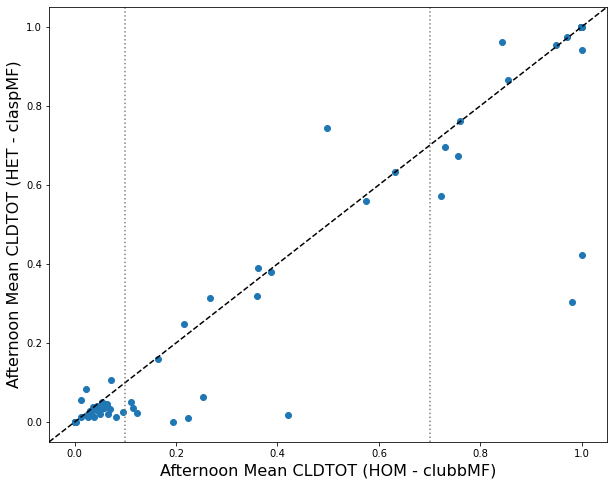

In [62]:
fig,axs = plt.subplots(1,1,figsize=(10,8))

plt.scatter(aftnDS.CLDTOT.sel(case='clubbMF'), aftnDS.CLDTOT.sel(case='clasp+MF'))
plt.plot(np.arange(-0.5,1.5,0.1), np.arange(-0.5,1.5,0.1),'k--')
axs.set_xlim([-0.05, 1.05])
axs.set_ylim([-0.05, 1.05])

axs.set_xlabel('Afternoon Mean CLDTOT (HOM - clubbMF)', fontsize=16)
axs.set_ylabel('Afternoon Mean CLDTOT (HET - claspMF)', fontsize=16)

axs.axvline(0.1, color='grey',linestyle=':')
axs.axvline(0.7, color='grey',linestyle=':')



In [58]:
## So take a look at just these partially cloudy days
partCldDays = np.where((aftnDS.CLDTOT.sel(case='clubbMF').values>0.1) & 
                       (aftnDS.CLDTOT.sel(case='clubbMF').values<0.7))[0]

partCldDS_daily = aftnDS.isel(time=partCldDays)

## Get full time-res data for those days too 
selTimes = []
selTimes_h2 = []
for iDay in range(len(partCldDS_daily.time.values)): 
    iTimes = np.where( (scamDS['time.year'].values==partCldDS_daily['time.year'].values[iDay]) & 
                       (scamDS['time.month'].values==partCldDS_daily['time.month'].values[iDay]) & 
                       (scamDS['time.day'].values==partCldDS_daily['time.day'].values[iDay]) )[0]
    
    iTimes_h2 = np.where( (scamDS_h2['time.year'].values==partCldDS_daily['time.year'].values[iDay]) & 
                          (scamDS_h2['time.month'].values==partCldDS_daily['time.month'].values[iDay]) & 
                          (scamDS_h2['time.day'].values==partCldDS_daily['time.day'].values[iDay]) )[0]

    selTimes = np.append(selTimes,iTimes).astype(int)
    selTimes_h2 = np.append(selTimes_h2,iTimes_h2).astype(int)

scamDS_partCld    = scamDS.isel(time=selTimes)
scamDS_h2_partCld = scamDS_h2.isel(time=selTimes)


In [59]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS_partCld.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS_partCld.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS_partCld.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2_partCld.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2_partCld.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2_partCld.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)



In [60]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2




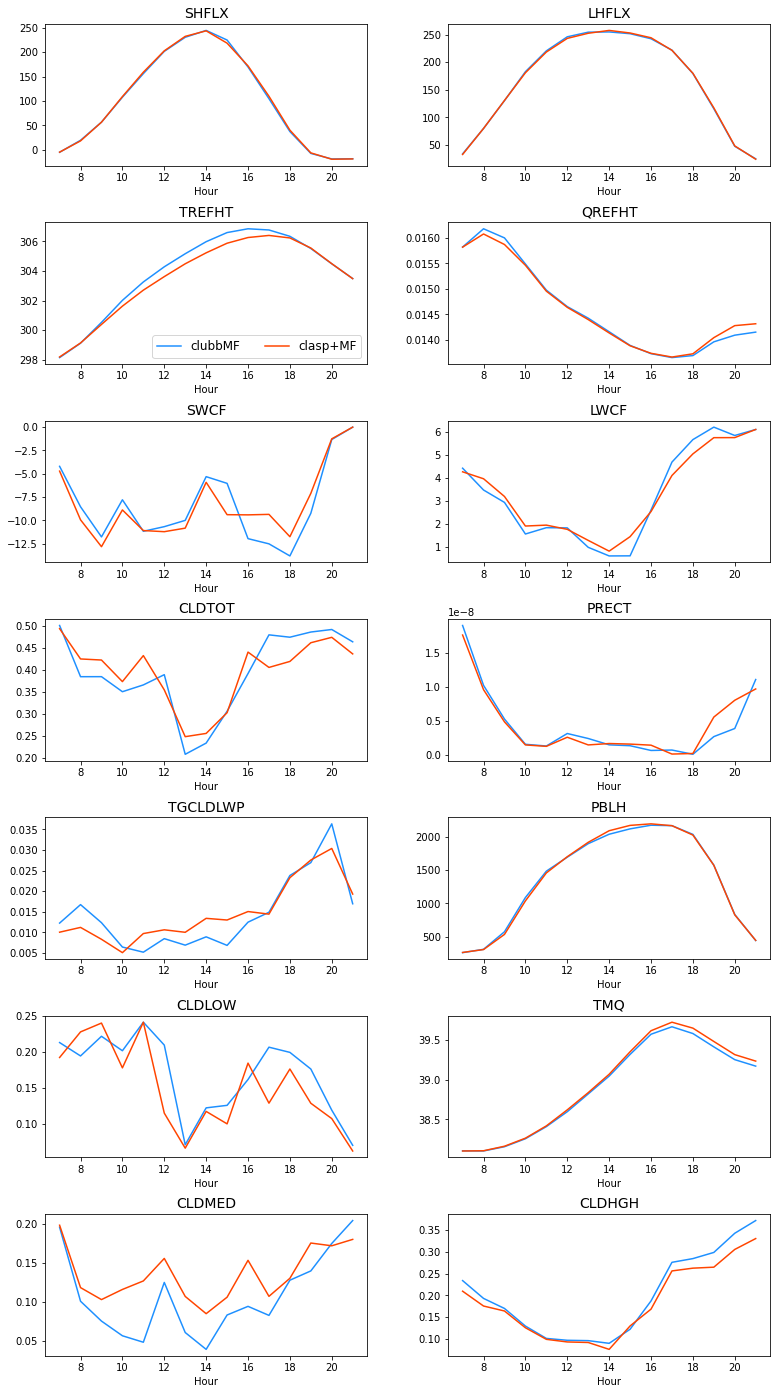

In [61]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ',
           'CLDMED','CLDHGH']

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

ctrlCase2 = 'clubbMF_setSfcFlux'
testCase2 = 'claspMF_setSfcFlux'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
    
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    if iPlt==2:
        axs[iPlt].legend(fontsize=12, ncol=2)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


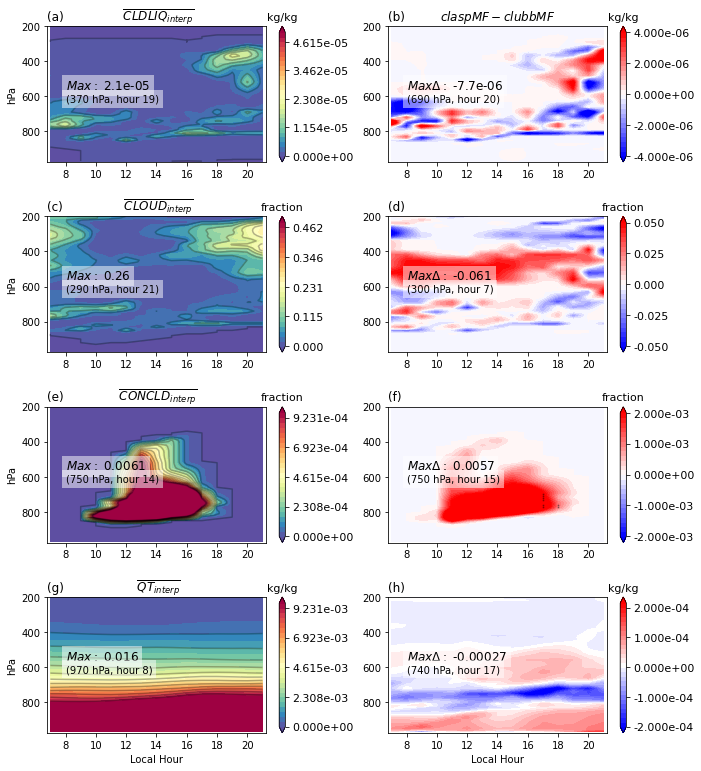

In [62]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.1e-2,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 200

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater




subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        




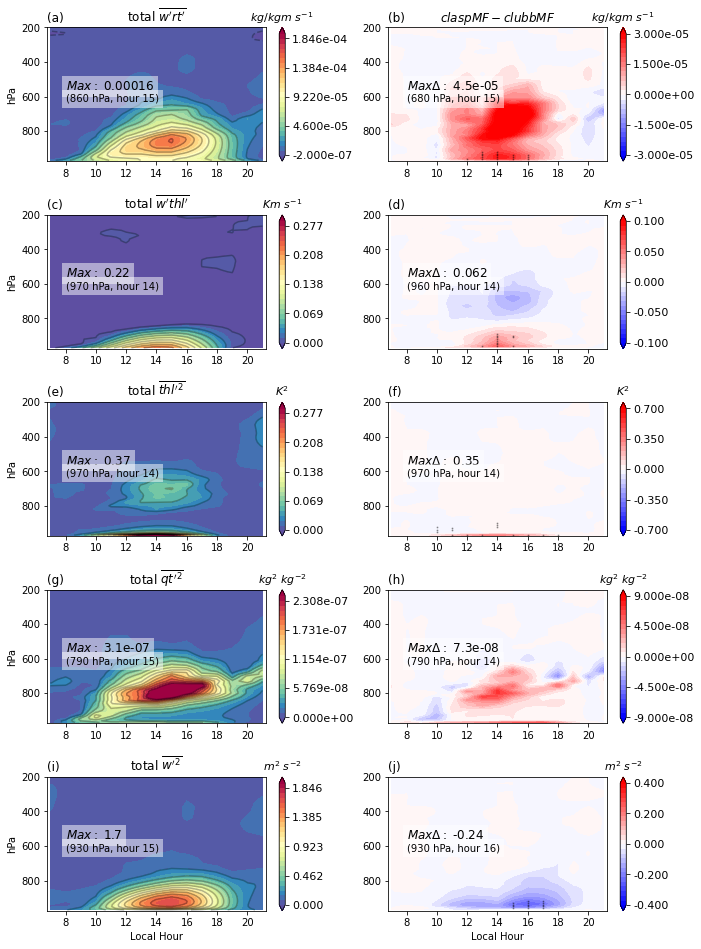

In [63]:
# Set up figure
pltVars  = [
            'total_wprtp',
            'total_wpthlp', 
            'total_thlp2',
            'total_rtp2',
            'total_wp2',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 200

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"total $\overline{w'rt'}$",
               r"total $\overline{w'thl'}$",
               r"total $\overline{thl'^2}$",
               r"total $\overline{qt'^2}$",
               r"total $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                             len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


### Time-height plots

In [63]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)


In [64]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2




**SCAM HOM case and HET-HOM case**

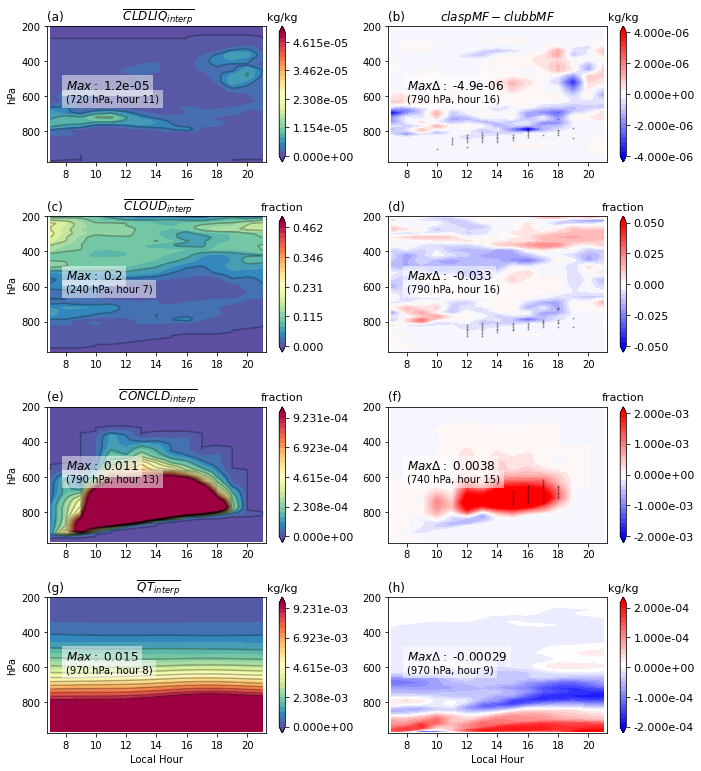

In [65]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.1e-2,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 200

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater




subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        




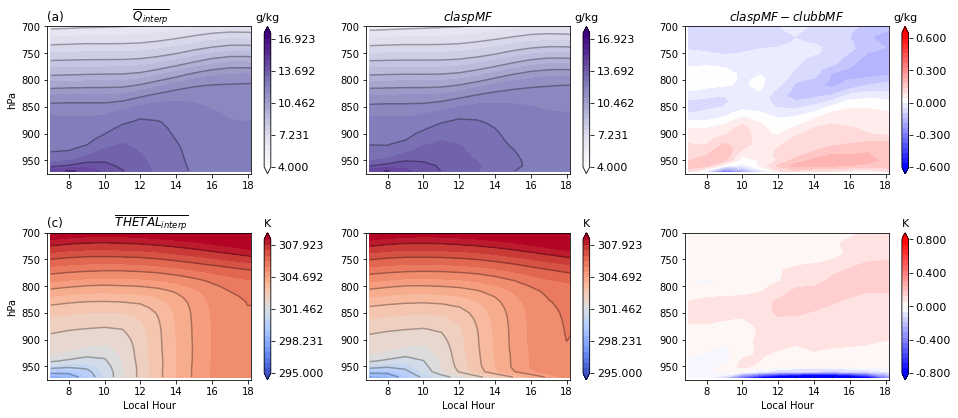

In [66]:
# Set up figure
pltVars  = ['Q_interp',
            'THETAL_interp',
           ]

cMin    = [4, 
           295.0,
          ]

cMax    = [18,
           309,
          ]

diffMax = [0.6,
           0.8,
          ]

multpl = [
          1e3,
          1,
         ]

maxLev  = 700

units = [
         r'g/kg',
         r'K',
        ]

cfmt_hmg = ['%.3f', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3f', '%.3f'] # colorbar label formater

cmapSel = ['Purples', 'coolwarm']


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{Q_{interp}}$",
               r" $\overline{THETAL_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 3, figsize=(16,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*3].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*3].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[iVar*3].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[iVar*3].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    # - - - - Plot test case - - - -
    cplt = axs[(iVar*3)+1].contourf(testDS.hour.values, testDS.levInterp.values, 
                       np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[(iVar*3)+1].contour(testDS.hour.values, testDS.levInterp.values, 
                    np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(testDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[(iVar*3)+1].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+1].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*3)+2].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+2], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
#     ## Add inset text for max difference 
#     diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
#     axs[(iVar*3)+2].text(8,760,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+2].text(8,830,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*3)+2].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*3].invert_yaxis()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+2].invert_yaxis()

    axs[(iVar*3)].set_ylim([975, maxLev])
    axs[(iVar*3)+1].set_ylim([975, maxLev])
    axs[(iVar*3)+2].set_ylim([975, maxLev])

    axs[(iVar*3)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*3)].set_title(varLabel[iVar])
    
    if iVar==0:
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*3)+2].set_title(r'$claspMF - clubbMF$')
        axs[(iVar*3)+1].set_title(r'$claspMF$')
#     else: 
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*3)].set_ylabel('hPa')
    
    axs[(iVar*3)].set_xlim([6.8,18.2])
    axs[(iVar*3)+1].set_xlim([6.8,18.2])
    axs[(iVar*3)+2].set_xlim([6.8,18.2])
    axs[(iVar*3)].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+1].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+2].set_xticks([8,10,12,14,16,18])

    
    if iVar==len(pltVars)-1: 
        axs[(iVar*3)].set_xlabel('Local Hour')
        axs[(iVar*3)+1].set_xlabel('Local Hour')
        axs[(iVar*3)+2].set_xlabel('Local Hour')

plt.show()


In [67]:
# CI_h2           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2']
# ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'], -CI_h2])

# ctrlDS_lowCI

In [68]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [69]:
getStatSigCI?

Signature: getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase)
Docstring: <no docstring>
File:      ~/Analysis/CLASP_MF/AnalysisScripts/<ipython-input-16-ebc418e848b9>
Type:      function


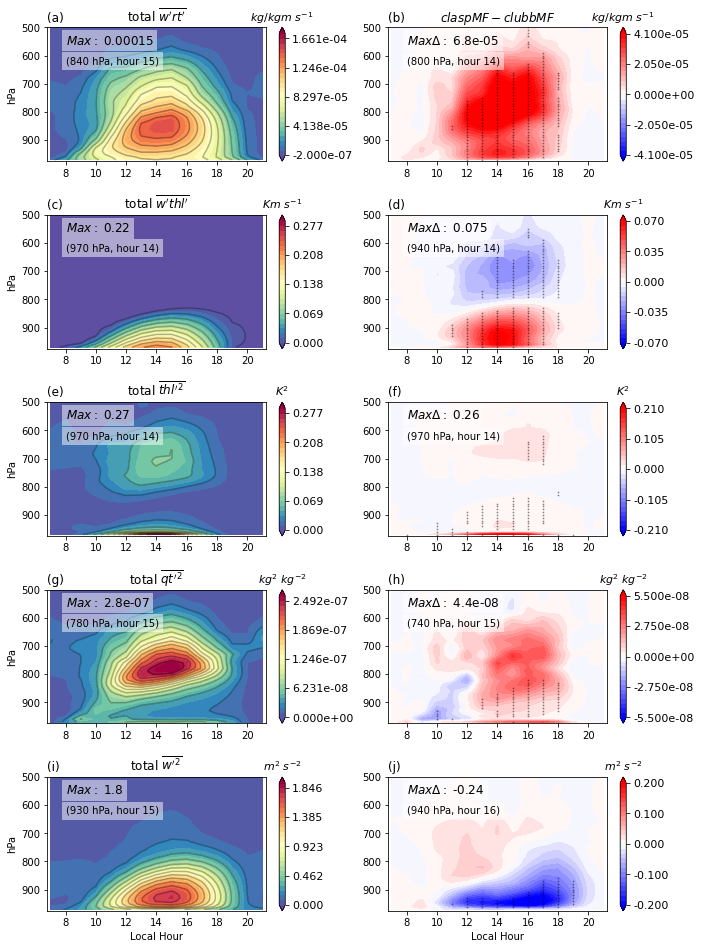

In [70]:
# Set up figure
pltVars  = [
            'total_wprtp',
            'total_wpthlp', 
            'total_thlp2',
            'total_rtp2',
            'total_wp2',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           1.8e-4,
           0.3,
           0.3,
           2.7e-7,
           2.0,
          ]

diffMax = [
           4.1e-5,
           0.07,
           0.21, 
           5.5e-8,
           0.2,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"total $\overline{w'rt'}$",
               r"total $\overline{w'thl'}$",
               r"total $\overline{thl'^2}$",
               r"total $\overline{qt'^2}$",
               r"total $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                             len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


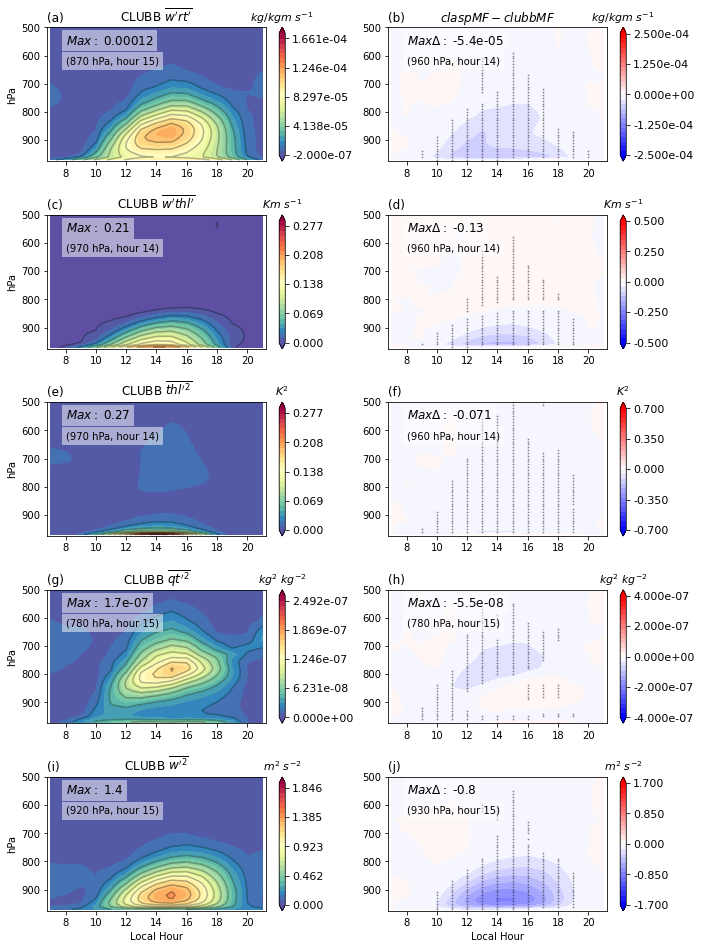

In [76]:
# Set up figure -- CLUBB components 
pltVars  = [
            'wprtp_interp',
            'wpthlp_interp', 
            'THLP2_CLUBB_interp',
            'RTP2_CLUBB_interp',
            'WP2_CLUBB_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           1.8e-4,
           0.3,
           0.3,
           2.7e-7,
           2.0,
          ]

diffMax = [
           2.5e-4,
           0.5,
           0.7, 
           4e-7,
           1.7,
          ]

multpl = [
          1,
          1,
          1,
          1e-6, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"CLUBB $\overline{w'rt'}$",
               r"CLUBB $\overline{w'thl'}$",
               r"CLUBB $\overline{thl'^2}$",
               r"CLUBB $\overline{qt'^2}$",
               r"CLUBB $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


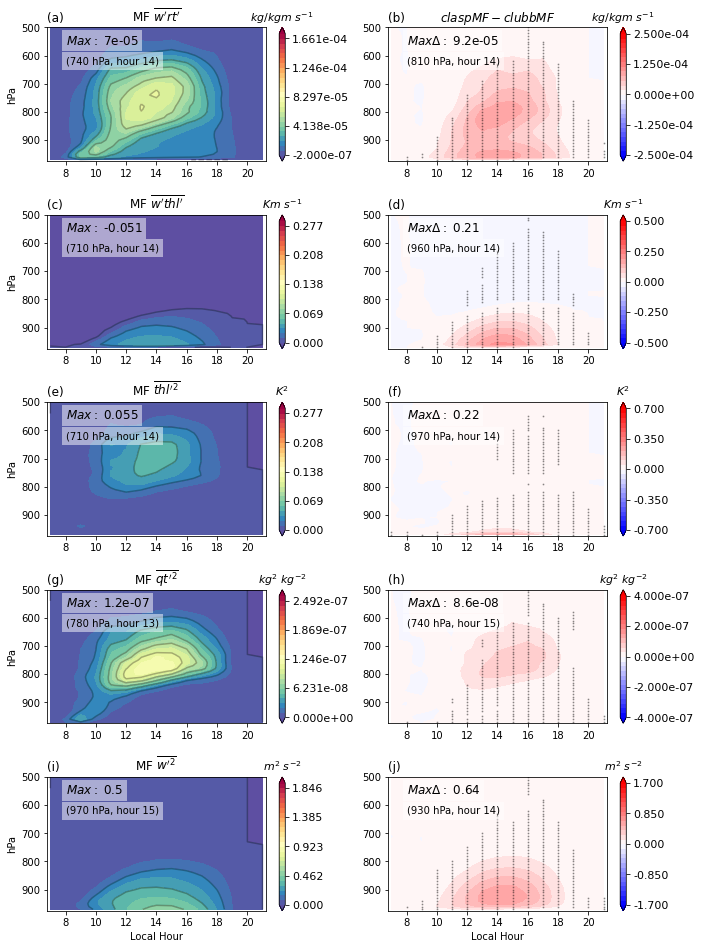

In [77]:
# Set up figure -- EDMF components 
pltVars  = [
            'edmf_qtflxup_interp',
            'edmf_thlflxup_interp', 
            'edmf_S_ATHLTHL_interp',
            'edmf_S_AQTQT_interp',
            'edmf_S_AWW_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           1.8e-4,
           0.3,
           0.3,
           2.7e-7,
           2.0,
          ]

diffMax = [
           2.5e-4,
           0.5,
           0.7, 
           4e-7,
           1.7,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"MF $\overline{w'rt'}$",
               r"MF $\overline{w'thl'}$",
               r"MF $\overline{thl'^2}$",
               r"MF $\overline{qt'^2}$",
               r"MF $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


### And in LES?

In [76]:
## u2 and v2 are on the same vertical grid, but w2 is not. Problem is that I don't have pressure levels for 
##    those inbetween levels...

## Interpolate w2 to those heights? 
hgtGoal = LES_allDays_allVarsHr.z
hgtNow  = LES_allDays_allVarsHr.zw

interpW2 = np.full([len(LES_allDays_allVarsHr.time.values),
                    len(LES_allDays_allVarsHr.case.values), len(LES_allDays_allVarsHr.k.values)], np.nan)

for iCase in range(len(LES_allDays_allVarsHr.case.values)): 
    for iT in range(len(LES_allDays_allVarsHr.time.values)):
        zTime = hgtGoal[iT,:].isel(case=iCase).values
        zNow  = hgtNow[iT,:].isel(case=iCase).values
        w2Now = LES_allDays_allVarsHr.w2.isel(case=iCase).values[iT,:]

        interpW2[iT, iCase, :] = interpolate.interpolate_1d(zTime, zNow, w2Now)

LES_allDays_allVarsHr['interp_w2'] = (('time','case','k'), interpW2)
TKE_total = LES_allDays_allVarsHr.u2.values + LES_allDays_allVarsHr.v2.values + LES_allDays_allVarsHr.interp_w2.values

LES_allDays_allVarsHr['TKE_total'] = (('time','case','k'), TKE_total)


In [77]:
hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
hrLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')

## Get time array to be 2D as well, so we can directly contourf the height, not using the mean value
hrArr_2d     = np.transpose( np.tile(hrLES_newDefault.hour.values, (226,1) ) )
hrArr_2d_227 = np.transpose( np.tile(hrLES_newDefault.hour.values, (227,1) ) )

## Get height axis
hgtAx = hrLES_newDefault.AVP_P * 1e-2

## Get hourly mean SCAM 
hrLESstd_newDefault       = LES_newDefault.groupby('Time.hour').std(dim='Time')
hrLESstd_moments          = LES_allDays_allVarsHr.groupby('time.hour').std(dim='time')

hourlyCountLES_newDefault = LES_newDefault.groupby('Time.hour').count(dim='Time')
hourlyCountLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').count(dim='time')


hourlySE_LESdefault = hrLESstd_newDefault/np.sqrt(hourlyCountLES_newDefault)
hourlySE_LESmoments = hrLESstd_moments/np.sqrt(hourlyCountLES_moments)

## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI_LESdefault = CIlevel*hourlySE_LESdefault
CI_LESmoments = CIlevel*hourlySE_LESmoments

lowCI_LESdefault = hrLES_newDefault - CI_LESdefault
hghCI_LESdefault = hrLES_newDefault + CI_LESdefault

lowCI_LESmoments = hrLES_moments - CI_LESmoments
hghCI_LESmoments = hrLES_moments + CI_LESmoments

def getStatSigCI_LES(lowCI_DS, highCI_DS, nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_DS.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_DS.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = highCI_DS.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = highCI_DS.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig



In [78]:
def getMaxValHeightTime_LES(DS,varName, levArr, maxLev, timeName):
    
    # Select levels of interest (varies by hour) 
    limitVar = np.full([np.shape(levArr)[0], np.shape(levArr)[2]], np.nan)

    for iHr in range(len(DS['hour'].values)): 
        maxVal = np.where(levArr.sel(case='HMG')[iHr,:]>=500)[0]
        limitVar[iHr,maxVal.astype(int)] = DS[varName].values[iHr,maxVal.astype(int)]
    
    
    
    maxValTemp = np.nanmax(np.squeeze(limitVar))
    minValTemp = np.nanmin(np.squeeze(limitVar))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax    = np.where(DS[varName].values == maxVal)
    hgtMax  = levArr.sel(case='HMG').values[iMax[0], iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

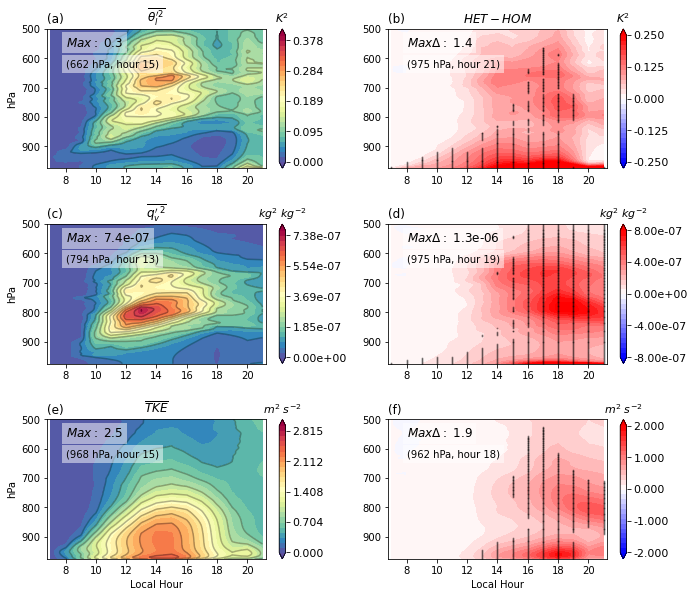

In [79]:
## Possible update for readability: Go vertical, not horizontal

# Set up figure
pltVars  = ['thl2', 'qv2', 'TKE_total']

cMin    = [0.0, 
           0.0, 
           0.0,
          ]

cMax    = [0.41, 
           0.8e-6,
           3.05,
          ]

cfmt_hmg = ['%.3f', '%.2e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3f', '%.2e', '%.3f'] # colorbar label formater

diffMax = [0.25, 
           0.8e-6,
           2.0,
          ]

multpl = [1, 
          1, 
          0.5, 
         ]

maxLev  = 500

units = [r'$K^2$',
         r'$kg^2$ $kg^{-2}$',
         r'$m^2$ $s^{-2}$',
        ]

subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [r"$\overline{\theta_l'^2}$", 
               r"$\overline{q_v'^2}$",
               r"$\overline{TKE}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'HMG'
testCase = 'HTG'

ctrlDS    = hrLES_moments.sel(case=ctrlCase)
testDS    = hrLES_moments.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(hrArr_2d, hgtAx.sel(case='HMG').values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar 
    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(hrArr_2d, hgtAx.sel(case='HMG').values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime_LES(ctrlDS, pltVars[iVar], hgtAx, maxLev,'hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(hrArr_2d, hgtAx.sel(case='HMG').values,  
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime_LES(diffCases, pltVars[iVar], hgtAx, maxLev,'hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    nTimes = len(hrLES_newDefault.hour.values)
    nLevs  = np.shape(hgtAx.sel(case='HMG').values)[1]
    
    levSig    = getStatSigCI_LES(lowCI_LESmoments, hghCI_LESmoments, 
                                 nTimes, nLevs, pltVars[iVar], ctrlCase, testCase)

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.k.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(hrArr_2d[iHr,iLev], hgtAx.sel(case='HMG').values[iHr,iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$HET - HOM$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        

# fig.savefig('/glade/u/home/mdfowler/Analysis/SCAMvLES_figs/Fig1_paperUPDATED.png')


## Look at some direct comparisons by day?

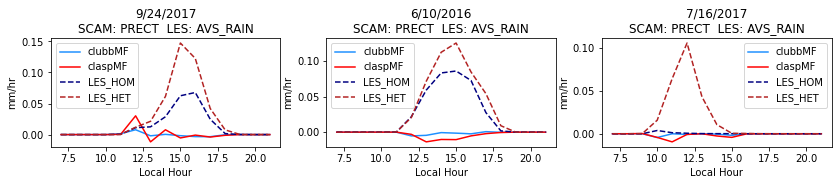

In [116]:
yrSelList  = [2017,2016,2017]
monSelList = [9,   6,   7]
daySelList = [24,  10,  16]

fig,axs= plt.subplots(1,3, figsize=(14,2))
axs  = axs.ravel()

varPlotSCAM = 'PRECT'
varPlotLES  = 'AVS_RAIN'

ymin = 0.0
ymax = 0.2

for iDay in range(len(yrSelList)):
    iselDate   = np.where( (scamDS['time.year'].values==yrSelList[iDay]) & 
                           (scamDS['time.month'].values==monSelList[iDay]) & 
                           (scamDS['time.day'].values==daySelList[iDay]) )[0]
    scamSelDay = scamDS.isel(time=iselDate).groupby('time.hour').mean(dim='time')
    
    
    iselDateLES  = np.where( (LES_newDefault['Time.year'].values==yrSelList[iDay]) & 
                             (LES_newDefault['Time.month'].values==monSelList[iDay]) & 
                             (LES_newDefault['Time.day'].values==daySelList[iDay]) )[0]
    lesSelDay   = LES_newDefault.isel(Time=iselDateLES).groupby('Time.hour').mean(dim='Time')
    
    
    axs[iDay].plot(scamSelDay['hour'].values, np.squeeze(scamSelDay.sel(case='clubbMF')[varPlotSCAM].values)*1000*3600, 
                                                              color='dodgerblue', label='clubbMF')
    axs[iDay].plot(scamSelDay['hour'].values, np.squeeze(scamSelDay.sel(case='clasp+MF')[varPlotSCAM].values)*1000*3600, 
                                                              color='red', label='claspMF')
                   
    axs[iDay].plot(lesSelDay['hour'].values, np.squeeze(lesSelDay.sel(case='HMG')[varPlotLES].mean(("south_north", "west_east")).values)*3600, 
                                                              '--',color='navy', label='LES_HOM')
    axs[iDay].plot(lesSelDay['hour'].values, np.squeeze(lesSelDay.sel(case='HTG')[varPlotLES].mean(("south_north", "west_east")).values)*3600, 
                                                              '--',color='firebrick', label='LES_HET')

    axs[iDay].legend()
    axs[iDay].set_title(str(monSelList[iDay])+'/'+str(daySelList[iDay])+'/'+str(yrSelList[iDay])+'\nSCAM: '+varPlotSCAM+'  LES: '+varPlotLES)
    
    axs[iDay].set_ylabel('mm/hr')
    axs[iDay].set_xlabel('Local Hour')
    # axs[iDay].set_ylim([ymin,ymax])
    

In [70]:
np.squeeze(scamSelDay.sel(case='clasp+MF')['PRECT'])

<xarray.DataArray 'PRECT' (hour: 15)>
array([ 0.0000000e+00,  0.0000000e+00,  9.8968238e-12, -5.5460303e-10,
       -3.9828518e-09,  3.8800674e-11, -1.1727937e-10, -7.0399225e-10,
        1.8582878e-11,  9.0781739e-13, -5.6509502e-12,  1.2942049e-12,
        1.4753406e-19,  1.3678952e-24,  0.0000000e+00], dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    case     <U8 'clasp+MF'
  * hour     (hour) int64 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21

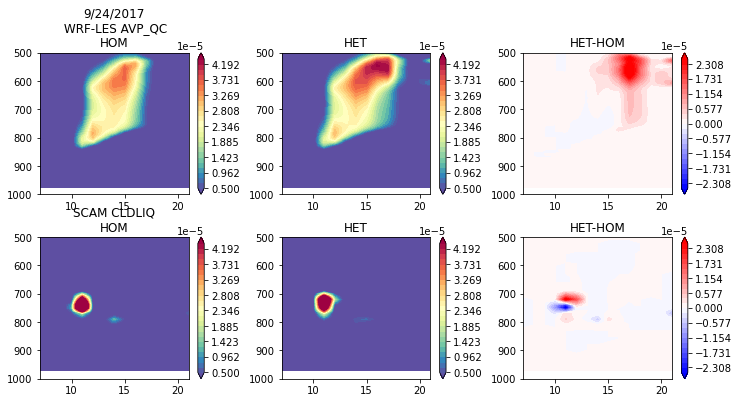

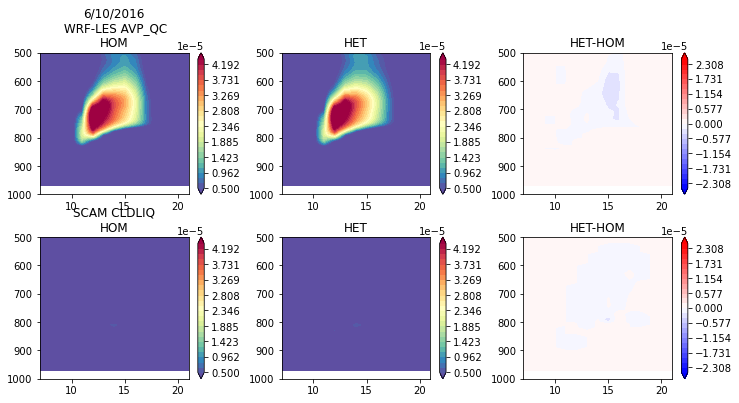

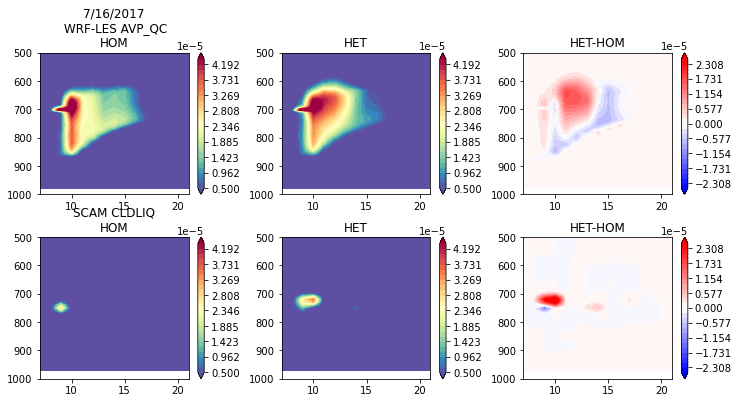

In [131]:

cMin = 0.5e-5
cMax = 4.5e-5
dMax = 2.5e-5

for iDay in range(len(yrSelList)):
    iselDate   = np.where( (scamDS['time.year'].values==yrSelList[iDay]) & 
                           (scamDS['time.month'].values==monSelList[iDay]) & 
                           (scamDS['time.day'].values==daySelList[iDay]) )[0]
    scamSelDay = scamDS.isel(time=iselDate).groupby('time.hour').mean(dim='time')
    
    
    iselDateLES  = np.where( (LES_newDefault['Time.year'].values==yrSelList[iDay]) & 
                             (LES_newDefault['Time.month'].values==monSelList[iDay]) & 
                             (LES_newDefault['Time.day'].values==daySelList[iDay]) )[0]
    lesSelDay   = LES_newDefault.isel(Time=iselDateLES).groupby('Time.hour').mean(dim='Time')
    
    ## Help for LES plots 
    hrArr_2d     = np.transpose( np.tile(lesSelDay.hour.values, (226,1) ) )
    hrArr_2d_227 = np.transpose( np.tile(lesSelDay.hour.values, (227,1) ) )
    hgtAx = lesSelDay.AVP_P * 1e-2

    ## Plot 2-D fields
    fig,axs = plt.subplots(2,3, figsize=(12,6))
    axs     = axs.ravel()
    
    
    ## PLOT WRF-LES RESULTS 
    cplt=axs[0].contourf(hrArr_2d, hgtAx.sel(case='HMG').values,
                    np.squeeze(lesSelDay.sel(case='HMG')['AVP_QC'].values),
                    np.arange(cMin, cMax, (cMax-cMin)/26),
                    cmap='Spectral_r', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[0])
    
    cplt=axs[1].contourf(hrArr_2d, hgtAx.sel(case='HTG').values,
                    np.squeeze(lesSelDay.sel(case='HTG')['AVP_QC'].values),
                    np.arange(cMin, cMax, (cMax-cMin)/26),
                    cmap='Spectral_r', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[1])
    
    cplt=axs[2].contourf(hrArr_2d, hgtAx.sel(case='HMG').values,
                    np.squeeze(lesSelDay.sel(case='HTG')['AVP_QC'].values)-np.squeeze(lesSelDay.sel(case='HMG')['AVP_QC'].values),
                    np.arange(-dMax, dMax, (dMax*2)/26),
                    cmap='bwr', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[2])
    
    
    ## PLOT SCAM RESULTS 
    cplt=axs[3].contourf(scamSelDay.hour.values, scamSelDay.levInterp.values,
                    np.squeeze(scamSelDay.sel(case='clubbMF')['CLDLIQ_interp'].values).transpose(),
                    np.arange(cMin, cMax, (cMax-cMin)/26),
                    cmap='Spectral_r', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[3])
    
    cplt=axs[4].contourf(scamSelDay.hour.values, scamSelDay.levInterp.values,
                    np.squeeze(scamSelDay.sel(case='clasp+MF')['CLDLIQ_interp'].values).transpose(),
                    np.arange(cMin, cMax, (cMax-cMin)/26),
                    cmap='Spectral_r', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[4])
    
    cplt=axs[5].contourf(scamSelDay.hour.values, scamSelDay.levInterp.values,
                    np.squeeze(scamSelDay.sel(case='clasp+MF')['CLDLIQ_interp'].values).transpose()-np.squeeze(scamSelDay.sel(case='clubbMF')['CLDLIQ_interp'].values).transpose(),
                    np.arange(-dMax, dMax, (dMax*2)/26),
                    cmap='bwr', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[5])   
    
    
    ## OTHER PLOT OPTIONS
    axs[0].set_title(str(monSelList[iDay])+'/'+str(daySelList[iDay])+'/'+str(yrSelList[iDay])+'\n WRF-LES AVP_QC'+'\nHOM')
    axs[1].set_title('\nHET')
    axs[2].set_title('\nHET-HOM')
    
    axs[3].set_title('SCAM CLDLIQ'+'\nHOM')
    axs[4].set_title('\nHET')
    axs[5].set_title('\nHET-HOM')
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    
    axs[0].set_ylim([1000,500])
    axs[1].set_ylim([1000,500])
    axs[2].set_ylim([1000,500])
    axs[3].set_ylim([1000,500])
    axs[4].set_ylim([1000,500])
    axs[5].set_ylim([1000,500])

    fig.subplots_adjust(wspace=0.3, hspace=0.3)


### Grab a few days at random and look at individual days

In [161]:
yrSelList  = [2017,2016,2017]
monSelList = [9,   6,   7]
daySelList = [24,  10,  16]

iselDate1 = np.where( (scamDS['time.year'].values==yrSelList[0]) & 
                      (scamDS['time.month'].values==monSelList[0]) & 
                      (scamDS['time.day'].values==daySelList[0]) )[0]
scamSel1 = scamDS.isel(time=iselDate1).groupby('time.hour').mean(dim='time')


iselDate2 = np.where( (scamDS['time.year'].values==yrSelList[1]) & 
                      (scamDS['time.month'].values==monSelList[1]) & 
                      (scamDS['time.day'].values==daySelList[1]) )[0]
scamSel2 = scamDS.isel(time=iselDate2).groupby('time.hour').mean(dim='time')


iselDate3 = np.where( (scamDS['time.year'].values==yrSelList[2]) & 
                      (scamDS['time.month'].values==monSelList[2]) & 
                      (scamDS['time.day'].values==daySelList[2]) )[0]
scamSel3 = scamDS.isel(time=iselDate3).groupby('time.hour').mean(dim='time')



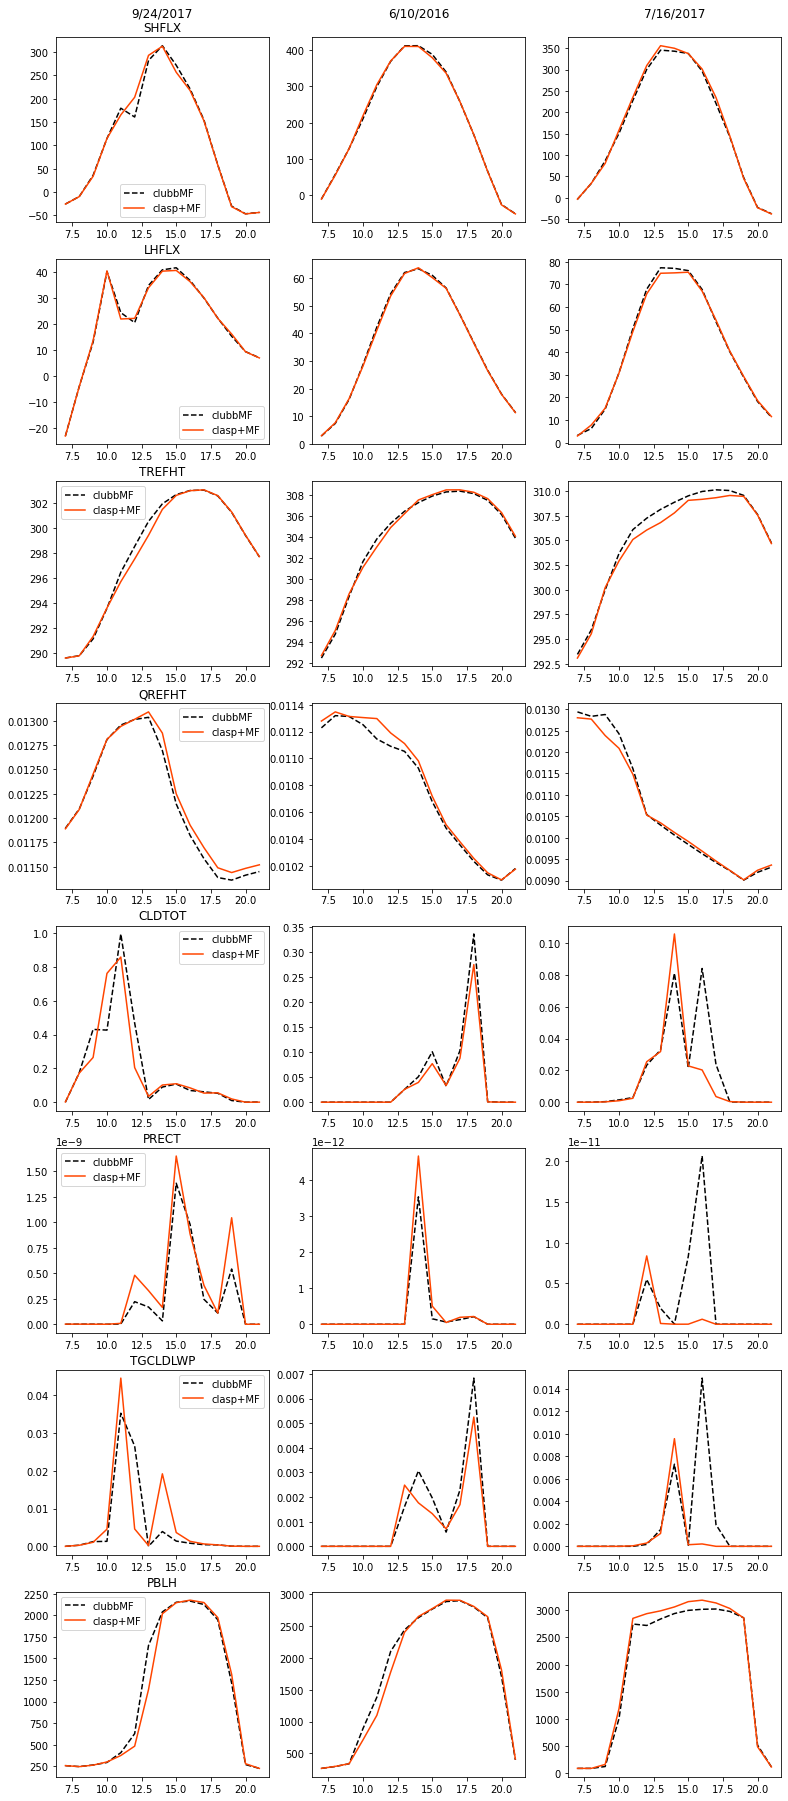

In [163]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
#            'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',]

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

fig,axs = plt.subplots(len(pltVars),3, figsize=(13,4*len(pltVars)))
axs     = axs.ravel()

for iPlt in range(len(pltVars)):

    ## Day 1
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    ## Day 2
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    ## Day 3
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    if iPlt==0: 
        axs[iPlt*3].set_title(str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0])+'\n'+pltVars[iPlt])
        axs[iPlt*3+1].set_title(str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1])+'\n')
        axs[iPlt*3+2].set_title(str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2])+'\n')
    else: 
        axs[iPlt*3].set_title(pltVars[iPlt])
        
    axs[iPlt*3].legend()
    
    

Text(0.5, 0, 'Local Hour')

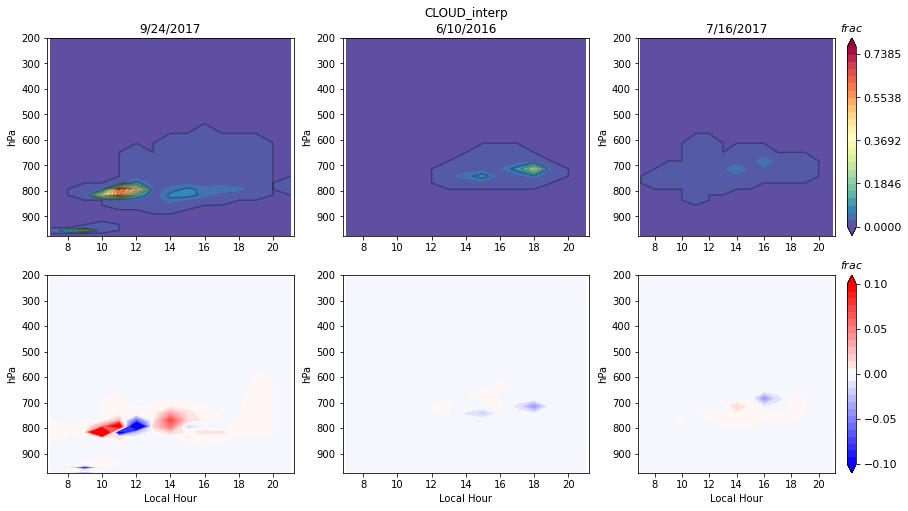

In [41]:
# pltVar  = 'THLP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 0.1
# diffMax = 0.01
# multpl  = 1 
# maxLev  = 500 
# unitsStr = r'$K^2$'

# pltVar  = 'RTP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 2.0e-7
# diffMax = 0.4e-7
# multpl  = 1e-6 
# maxLev  = 500 
# unitsStr = r'$kg^2/kg^2$'

pltVar  = 'CLOUD_interp'
cMin    = 0.0 
cMax    = 0.8
diffMax = 0.1
multpl  = 1 
maxLev  = 200 
unitsStr = r'$frac$'

fig,axs = plt.subplots(2,3, figsize=(15,8))
axs     = axs.ravel()

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 1 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel1.sel(case=ctrlCase)
testDS    = scamSel1.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[0].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[0].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )

# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[3].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 2
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel2.sel(case=ctrlCase)
testDS    = scamSel2.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[1].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[1].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[4].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 3 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel3.sel(case=ctrlCase)
testDS    = scamSel3.sel(case=testCase)
diffCases = testDS - ctrlDS

# - - - - Plot control case - - - -
cplt = axs[2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
if (pltVar=='RTPTHLP_CLUBB_interp'):
        cbar = fig.colorbar(cplt, ax=axs[2],ticks=[cMin, cMin/2, 0, cMax/2, cMax])
else: 
    cbar = fig.colorbar(cplt, ax=axs[2])
    cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 


# Add contour lines
cplt = axs[2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[5].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

cbar = fig.colorbar(cplt, ax=axs[5],ticks=[-diffMax, -diffMax/2, 0, diffMax/2, diffMax])
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Other plot options 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

axs[0].set_title('\n'+str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0]))
axs[1].set_title(pltVar+'\n'+str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1]))
axs[2].set_title('\n'+str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2]))

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()


axs[0].set_ylim([975, maxLev])
axs[1].set_ylim([975, maxLev])
axs[2].set_ylim([975, maxLev])
axs[3].set_ylim([975, maxLev])
axs[4].set_ylim([975, maxLev])
axs[5].set_ylim([975, maxLev])

axs[0].set_ylabel('hPa')
axs[1].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[3].set_ylabel('hPa')
axs[4].set_ylabel('hPa')
axs[5].set_ylabel('hPa')

axs[0].set_xlim([6.8,21.2])
axs[1].set_xlim([6.8,21.2])
axs[2].set_xlim([6.8,21.2])
axs[3].set_xlim([6.8,21.2])
axs[4].set_xlim([6.8,21.2])
axs[5].set_xlim([6.8,21.2])

axs[0].set_xticks([8,10,12,14,16,18,20])
axs[1].set_xticks([8,10,12,14,16,18,20])
axs[2].set_xticks([8,10,12,14,16,18,20])
axs[3].set_xticks([8,10,12,14,16,18,20])
axs[4].set_xticks([8,10,12,14,16,18,20])
axs[5].set_xticks([8,10,12,14,16,18,20])

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')


## Scratch work

In [69]:
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxTRUE_fixEvap.LASSO_20180605.budgetMFvars001'
caseDir = '/project/amp/mdfowler/cases/'
histDir = '/run/atm/hist/'

listFiles_h2 = np.sort(glob.glob(caseDir+caseName+histDir+'*cam.h2*'))

testDS = xr.open_dataset(listFiles_h2[0], decode_times=True)


(1000.0, 500.0)

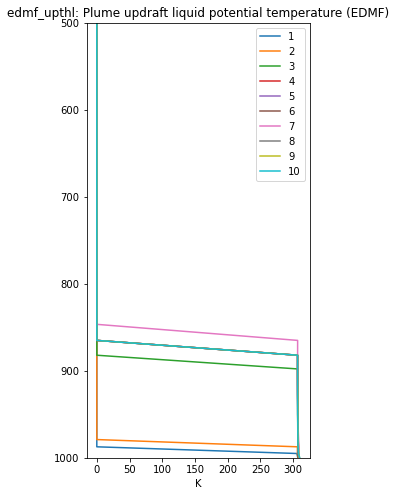

In [84]:
nens = 10
fig,axs = plt.subplots(1,1, figsize=(4,8))

pltVar = 'edmf_upthl'

for iEns in range(nens):
    axs.plot(testDS[pltVar].values[200,iEns,:,0,0], testDS.ilev.values,label=str(iEns+1))
    
axs.invert_yaxis()
axs.legend()
axs.set_title(pltVar+': '+testDS[pltVar].long_name)
axs.set_xlabel(testDS[pltVar].units)
axs.set_ylim([1000,500])


In [70]:
testDS

<xarray.Dataset>
Dimensions:         (ilev: 59, lat: 1, lev: 58, lon: 1, nbnd: 2, nens: 10, time: 865)
Coordinates:
  * lat             (lat) float64 36.6
  * lon             (lon) float64 262.5
  * lev             (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev            (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time            (time) object 2018-06-05 05:01:00 ... 2018-06-08 05:01:00
Dimensions without coordinates: nbnd, nens
Data variables:
    ntrk            int32 ...
    ntrn            int32 ...
    ntrm            int32 ...
    gw              (lat) float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    P0              float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    date            (time) int32 ...
    datesec         (time) int32 ...
    time_bnds       (time, nbnd) object ...
    date_written    (time) |S8 ...
    time_written    (time) |S8 ...
    ndbase          int32 ...
    nsbase          int32 ...
    nbdate          int32 ...
    nbsec           int32 ...
    mdt             int32 ...
    ndcur           (time) int32 ...
    nscur           (time) int32 ...
    co2vmr          (time) float64 ...
    ch4vmr          (time) float64 ...
    n2ovmr          (time) float64 ...
    f11vmr          (time) float64 ...
    f12vmr          (time) float64 ...
    sol_tsi         (time) float64 ...
    nsteph          (time) int32 ...
    edmf_DRY_A      (time, ilev, lat, lon) float32 ...
    edmf_DRY_QT     (time, ilev, lat, lon) float32 ...
    edmf_DRY_THL    (time, ilev, lat, lon) float32 ...
    edmf_DRY_W      (time, ilev, lat, lon) float32 ...
    edmf_MOIST_A    (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QC   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QT   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_THL  (time, ilev, lat, lon) float32 ...
    edmf_MOIST_W    (time, ilev, lat, lon) float32 ...
    edmf_cloudfrac  (time, lev, lat, lon) float32 ...
    edmf_dnqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_dnthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_dnw        (time, nens, ilev, lat, lon) float32 ...
    edmf_precc      (time, ilev, lat, lon) float32 ...
    edmf_qtflxdn    (time, ilev, lat, lon) float32 ...
    edmf_qtflxup    (time, ilev, lat, lon) float32 ...
    edmf_qtforcdn   (time, lev, lat, lon) float32 ...
    edmf_qtforcup   (time, lev, lat, lon) float32 ...
    edmf_rcm        (time, ilev, lat, lon) float32 ...
    edmf_thlflxdn   (time, ilev, lat, lon) float32 ...
    edmf_thlflxup   (time, ilev, lat, lon) float32 ...
    edmf_thlforcdn  (time, lev, lat, lon) float32 ...
    edmf_thlforcup  (time, lev, lat, lon) float32 ...
    edmf_upa        (time, nens, ilev, lat, lon) float32 ...
    edmf_upbuoy     (time, nens, ilev, lat, lon) float32 ...
    edmf_updet      (time, nens, ilev, lat, lon) float32 ...
    edmf_upent      (time, nens, ilev, lat, lon) float32 ...
    edmf_upmf       (time, nens, ilev, lat, lon) float32 ...
    edmf_upqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_upth       (time, nens, ilev, lat, lon) float32 ...
    edmf_upthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_upthv      (time, nens, ilev, lat, lon) float32 ...
    edmf_upw        (time, nens, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_set...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5